#Vorbereitung der Umgebung 
Bereitet die Umgebung vor, lädt die nötigen Dependencies und Libraries die im Projekt benötigt werden.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Path to root directory where project folder "IndoorTracking" is
root_path = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import joblib
import glob, os
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.utils import shuffle
import random
import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.ndimage import median_filter
from scipy.signal import wiener
from pykalman import KalmanFilter

from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

#Neues Datenset erstellen **(Optional)**
Kann ausgeführt werden wenn neue JSON Request erhoben worden sind und dies zu einem neuen Datenset / CSV umgewandelt werden sollte.

##Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [ ]:
path = f'{root_path}IndoorTrackingML/DATA/'

whitelist_majorminor = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+'JSON/')
dictionary_list = []

for json_file in glob.glob('*.json'):
  filename = os.path.splitext(json_file)[0]

  df = pd.read_json(path+'/JSON/'+filename+'.json',)

  #Iterates through all gateway traces
  for trace_index in range(len(df)):
    current_trace = df.iloc[trace_index]
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    trace_entries = current_trace.content.split('"')[3::2]
    for beacon_index in range(len(trace_entries)):
      beacon_data = trace_entries[beacon_index].split(',')

      if len(beacon_data[4]) >= 56: 
        #Extracts beacon data out of hex value
        beacon_type = beacon_data[4][6:18]
        uuid = beacon_data[4][18:50]
        major = int(beacon_data[4][50:54],16)
        minor = int(beacon_data[4][54:58],16)
        majorminor = int(str(major)+str(minor))
        timestamp = beacon_data[5]

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelist_majorminor:
          continue
        #General signal power strength set for beacons
        #The measured power equals the signal strength on 1 meter distance
        measured_power = -60

        #Specific power was set for beacon with the majorminor below given majorminor values
        #The values are extracted by reading the settings of each beacon via bluetooth connection
        if majorminor == 100656666:
          measured_power = -75
        elif majorminor == 100454480 or majorminor == 100422222:
          measured_power = -64
        elif majorminor == 100411111:
          measured_power = -56
        elif majorminor == 10029586 or majorminor == 10029571:
          measured_power = -61

        #Id of the tag of the Beacon
        tag_id = beacon_data[1]
        gateway = beacon_data[2]
        rssi = int(beacon_data[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measured_power - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tag_id, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beacon_type,
                'uuid':uuid}
        #Adds beacon to dictionary
        dictionary_list.append(beacon)
#Transforms dicitonary to dataframe (more efficent then concat)
transformed_df = pd.DataFrame.from_dict(dictionary_list)

#Cleaning of dublicates / multi entries which were recived with same timestamp
transformed_df[['distance','rssi']] = transformed_df.groupby(['timestamp','majorminor','gateway','uuid'])[['distance','rssi']].transform('median')
transformed_df = transformed_df.drop_duplicates().sort_values(by=['timestamp','gateway']).reset_index(drop=True)

transformed_df.to_csv(r''+path+'/CSV/CombinedGatewayData.csv', index=False)

NameError: ignored

##Labeling der Daten (Erweiterung CSV)
In diesem Abschnitt werden die CSV-Dateien welche aus JSON-Requests oder direkt aus einer Datenbank extrahiert wurden mit Labeln erweitert.
Hier zu muss ein LabelHelper.csv File ausgefüllt werden, da diese die Zeitpunkte / Timestamps enthalten man sich wann an welchem Punkt befunden hat um das entsprechende Label zu setzen.

In [ ]:
path = f'{root_path}/IndoorTrackingML/DATA/'
path_csv = path+'CSV/'

#Contains timestamp, tag and specific tag values for each measurepoint of data
timestamp_label_hepler_df = pd.read_csv(path+'LabelHelper.csv',sep=';')

os.chdir(path_csv)

frame = list()

for csv_file in glob.glob('*.csv'):
  df = pd.read_csv(path_csv + csv_file)

  #This iterates through all data which are within the valid timestamp which are defined in a helper csv file
  for index in range(len(timestamp_label_hepler_df)):
    selection = df.loc[(df.timestamp >= timestamp_label_hepler_df.iloc[index].firsttimestamp) & 
                       (df.timestamp <= timestamp_label_hepler_df.iloc[index].lasttimestamp)].copy()
    selection[['tag','specificTag']] = timestamp_label_hepler_df.iloc[index][['tag', 'specificTag']]
    frame.append(selection)
  
master_df = pd.concat(frame).drop_duplicates().reset_index(drop=True)
master_df.to_csv(r''+path_csv+'LabeledCombinedGatewayData.csv', index=False)
master_df.head()

#Rohdatenanalyse **(Optional)**
In diesem Abschnitt werden die grob aufbereiten Daten eingelesen und visuell aufbereitet um dies zu analysieren.

In [ ]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ['distance','rssi','gateway']
join_parameter = ['type','uuid','tag','specificTag','timestamp','major','majorminor','minor']

#Training
filepath = f'{root_path}IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv'
#Test closed Doors
#filepath = f'{root_path}IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
#filepath = f{root_path}IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'


master_df = pd.read_csv(filepath)

#Dinamical adapting on number of gateways used for experiment
gateways = master_df.gateway.unique()

#Creating new Dataframes
adapted_master_df = pd.DataFrame()
temp_df = pd.DataFrame()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
for gateway in gateways:
  beacon_measurements_of_gateway_df = master_df.loc[(master_df.gateway == gateway)].copy()
  #Columns which could be used as feature are expanded with Name of Gateway as suffix
  beacon_measurements_of_gateway_df.columns = [f'{col}_{gateway}' if col in features else col for col in beacon_measurements_of_gateway_df.columns]
    
  #Checks if temp Dataframe already has entries and has to be merged or a copy is 'dumped' in
  if len(temp_df) > 0:
    temp_df = pd.merge(temp_df,beacon_measurements_of_gateway_df, how='outer', on=join_parameter)
  else:
    temp_df = beacon_measurements_of_gateway_df.copy()
adapted_master_df = pd.concat([adapted_master_df, temp_df])
adapted_master_df.drop_duplicates(inplace=True)
temp_df.drop(temp_df.index , inplace=True)
adapted_master_df.reset_index(drop=True, inplace=True)

##Obsolet, da vermeindlich nur für Abhängigkeit der Gateways nützliche Plots

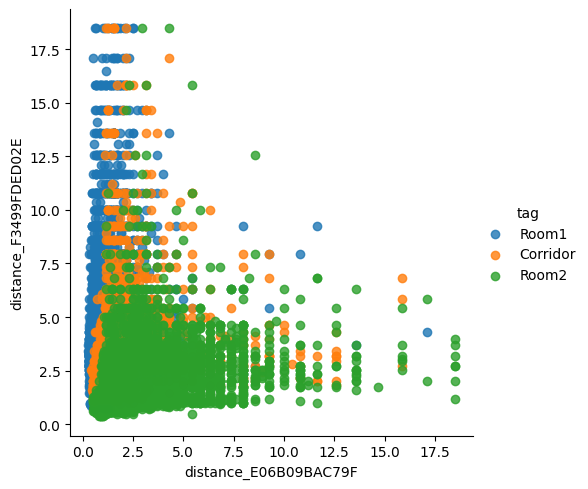

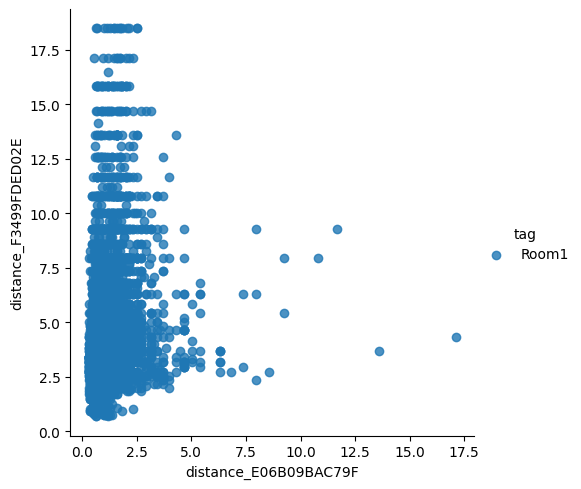

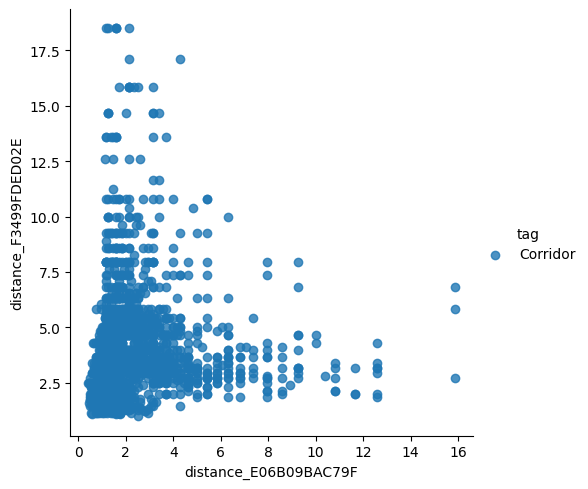

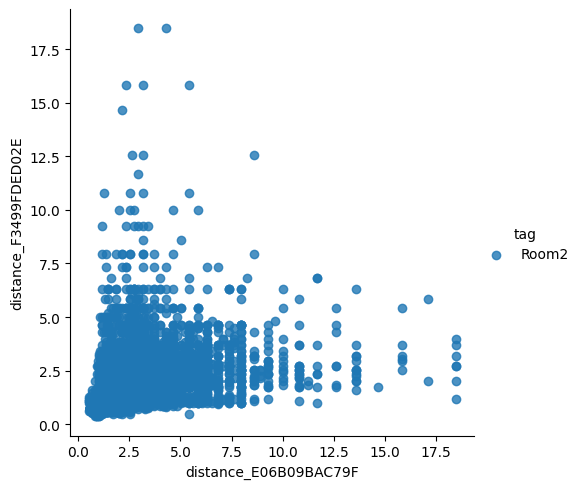

1072 - 100656666
2172 - 100029571
2154 - 1000454480
2158 - 1000411111
2172 - 100029586
1089 - 1230329194
2144 - 1000422222


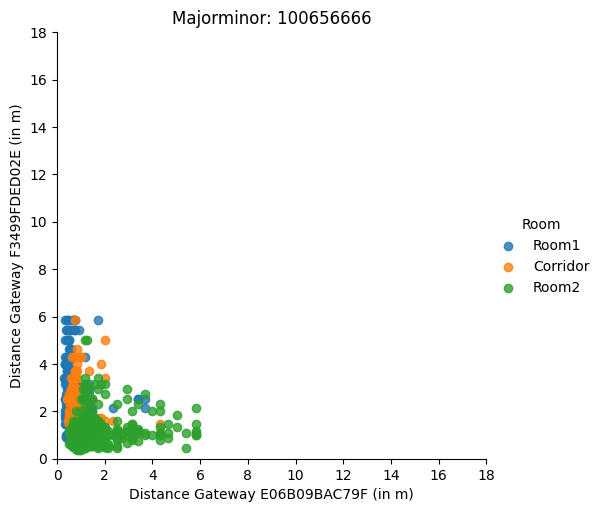

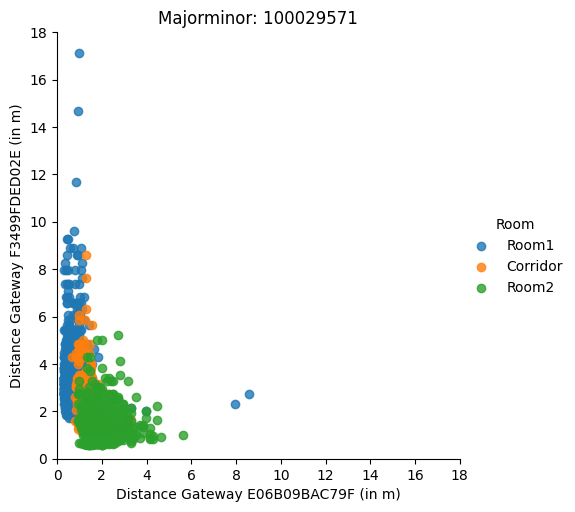

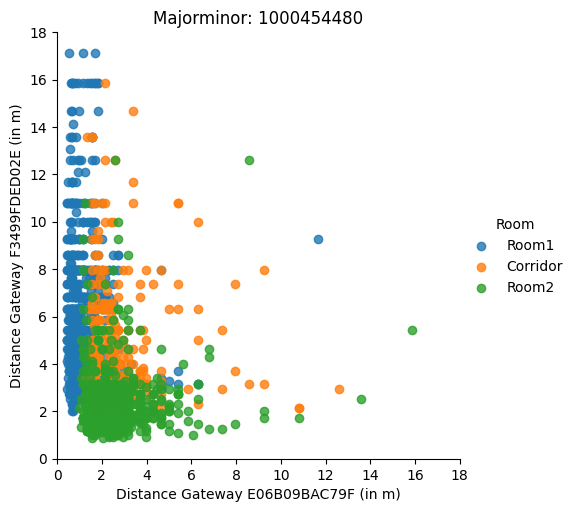

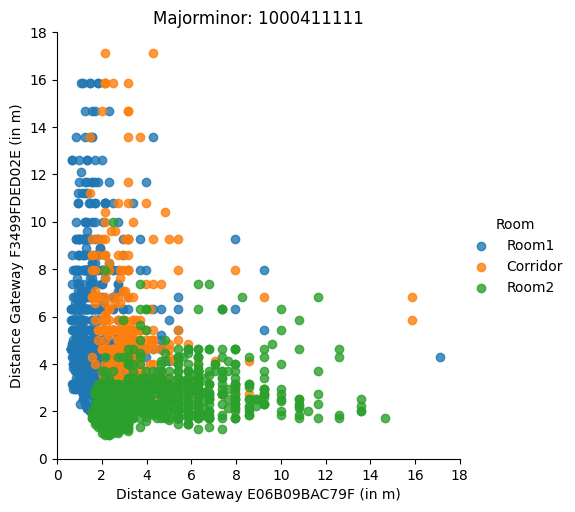

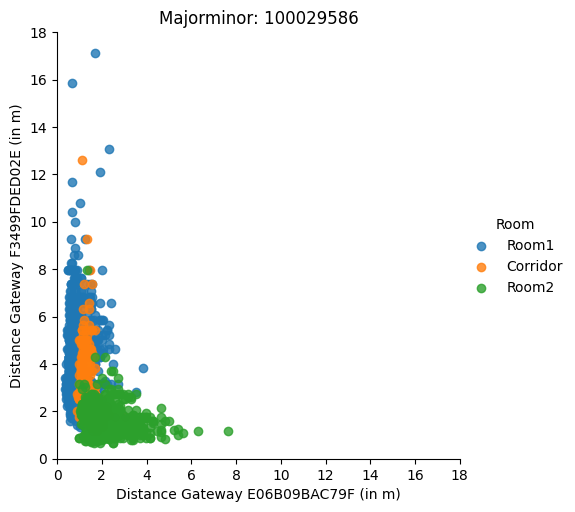

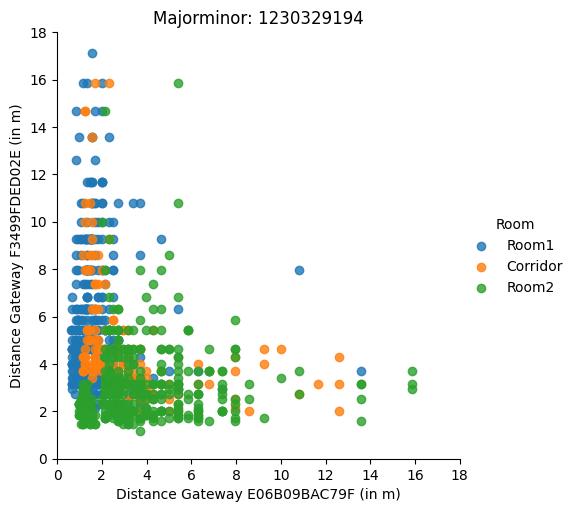

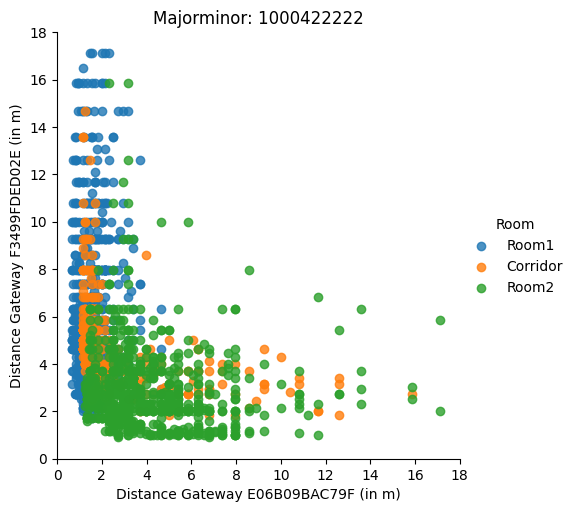

In [ ]:
##THIS PLOTS ARE CURRENTLY NOT REUQIRED AS WITH SEPERATION OF GATEWAYS THE
#ADDITIONAL INFORMATION OF DISTANCE AT A SPECIFIC TIMESTAMP AND THE VALUE OF 
#THE OTHER GATEWAY GIVES NO BENEFIT FOR INITIAL ANALYSATION 

#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

x_label_str = str(distance_column_names[0].split('_')[1])
y_label_str = str(distance_column_names[1].split('_')[1])

sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df, hue='tag', fit_reg=False)
for tag in adapted_master_df.tag.unique():
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df.loc[adapted_master_df.tag==tag], hue='tag', fit_reg=False)

plt.show()

for majorminor in adapted_master_df.majorminor.unique():
  df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor]
  ax = sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=df, hue='tag', fit_reg=False)
  
  ax.set(xlabel=f'Distance Gateway {x_label_str} (in m)',
         ylabel=f'Distance Gateway {y_label_str} (in m)')
  print(f'{len(df)} - {majorminor}')
  plt.title(f'Majorminor: {majorminor}')
  ax._legend.set_title('Room')
  ax.set(xlim=(0,18), ylim=(0, 18))

  
plt.show()
#for tag in adapted_master_df.tag.unique():
#  df = adapted_master_df.loc[adapted_master_df.tag == tag]
#  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='specificTag', fit_reg=False)
#  plt.show()

##Aktuelle Plots für Analyse

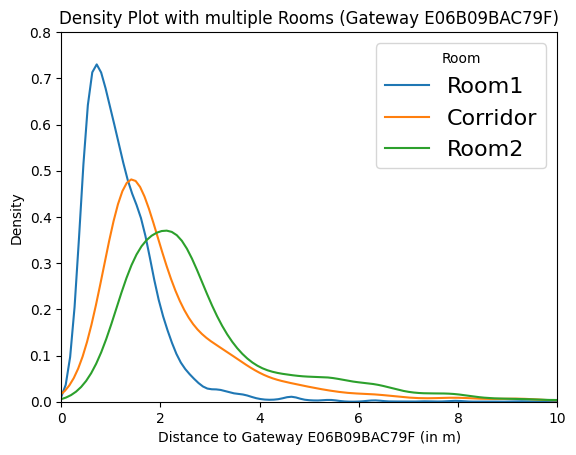

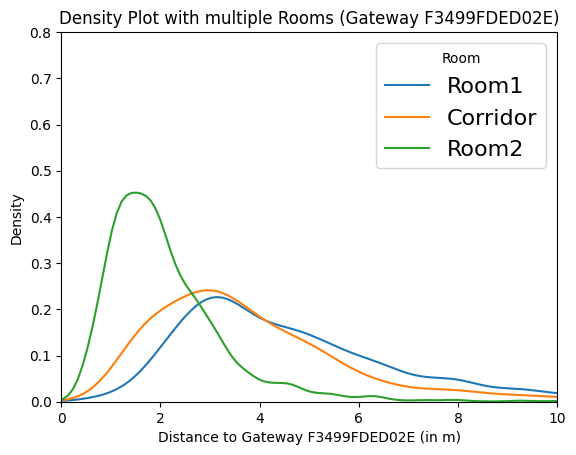

In [ ]:
#Gets all tags (can be modified to spefic tags etc)
tags = adapted_master_df.tag.unique()
#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

for distance_column in distance_column_names:
  gateway = str(distance_column.split('_')[1])
  #Iterates through the tags
  for tag in tags:
    #Subset to the specific tag
    subset = adapted_master_df[adapted_master_df['tag'] == tag]
    
    #Draw density plot
    ax = sns.kdeplot(subset[distance_column], label = tag)

    ax.set(xlabel=f'Distance Gateway {gateway} (in m)')
    ax.set(xlim=(0,10), ylim=(0, 0.8))
    
  #Plot formatting
  plt.legend(prop={'size': 16}, title = 'Room')
  plt.title(f'Density Plot with multiple Rooms (Gateway {gateway})')
  plt.xlabel(f'Distance to Gateway {gateway} (in m)')
  plt.ylabel('Density')
  plt.show()

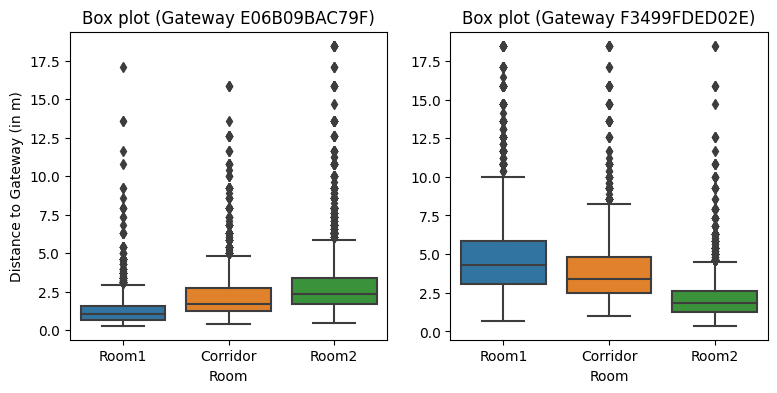

In [ ]:
#Box plot for each Gateway
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

for index, distance_column in enumerate(distance_column_names):  
  gateway = distance_column.split('_')[1]

  #Plot box plot
  sns.boxplot(ax=axs[index], x='tag', y=distance_column, data=adapted_master_df)
  axs[index].set_title(f'Box plot (Gateway {gateway})')
  #Plot Y-Label just for first plot
  if index > 0:
    axs[index].set(xlabel='Room',
                   ylabel='')
  else:
    axs[index].set(xlabel='Room',
                   ylabel='Distance to Gateway (in m)')

plt.show()

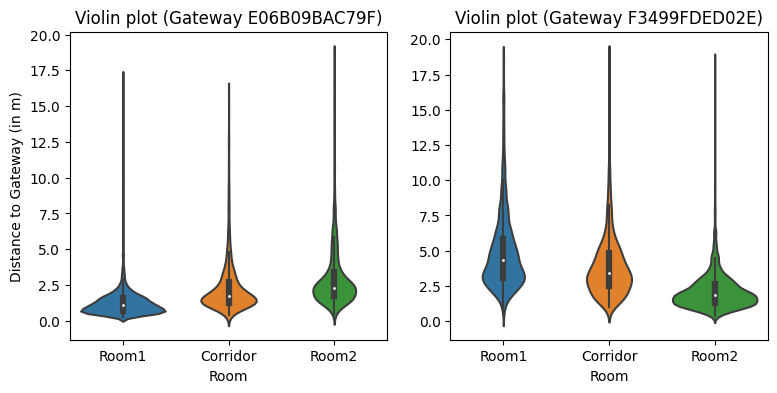

In [ ]:
#Violin plot for each gateway
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

for index, distance_column in enumerate(distance_column_names):  
  gateway = distance_column.split('_')[1]

  #Plot violin plot
  asdf = sns.violinplot(ax=axs[index], x='tag', y=distance_column, data=adapted_master_df)
  axs[index].set_title(f'Violin plot (Gateway {gateway})')
  #Plot Y-Label just for first plot
  if index > 0:
    axs[index].set(xlabel='Room',
                   ylabel='')
  else:
    axs[index].set(xlabel='Room',
                   ylabel='Distance to Gateway (in m)')
plt.show()

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


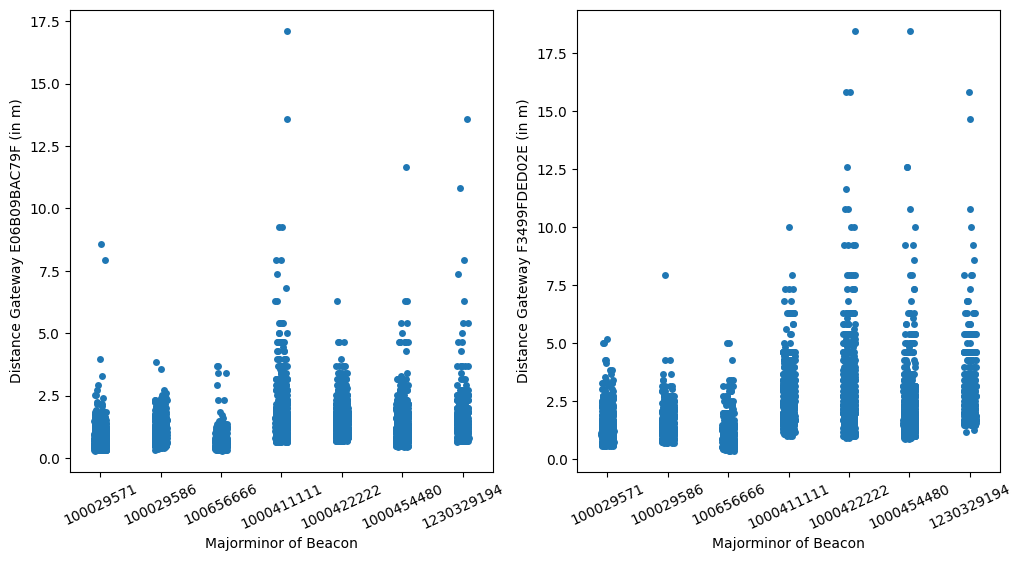

In [ ]:
#Shows range of values for each beacon for each gateway and it's specific allocated room

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = adapted_master_df.loc[(adapted_master_df.tag == "Room1") & (adapted_master_df.gateway_E06B09BAC79F == "E06B09BAC79F")]

axs[0] = sns.stripplot(ax=axs[0], x="majorminor", y="distance_E06B09BAC79F", data=df)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25)
axs[0].set(xlabel='Majorminor of Beacon',
           ylabel='Distance Gateway E06B09BAC79F (in m)')

df = adapted_master_df.loc[(adapted_master_df.tag == "Room2") & (adapted_master_df.gateway_F3499FDED02E == "F3499FDED02E")]

axs[1] = sns.stripplot(ax=axs[1], x="majorminor", y="distance_F3499FDED02E", data=df)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25)
axs[1].set(xlabel='Majorminor of Beacon',
           ylabel='Distance Gateway F3499FDED02E (in m)')
plt.show()

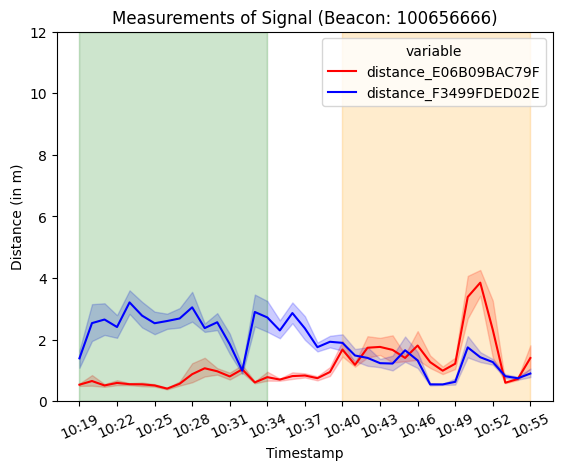

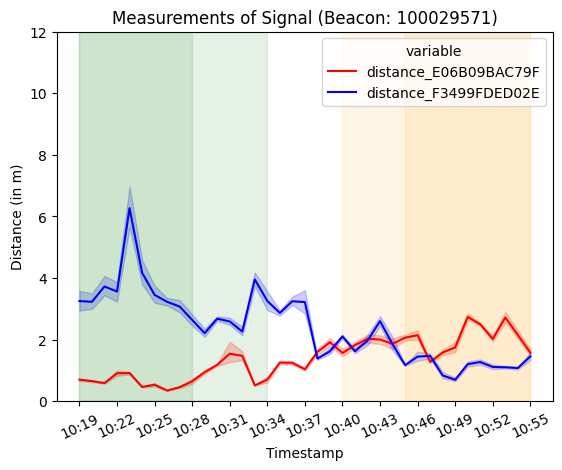

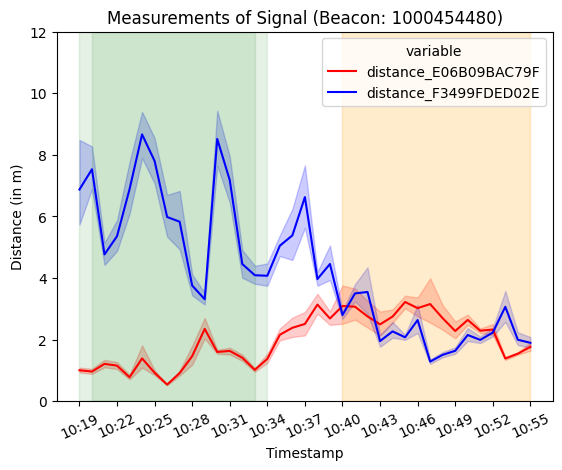

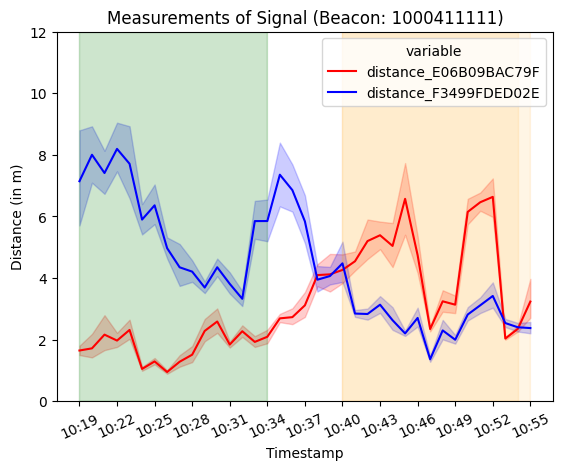

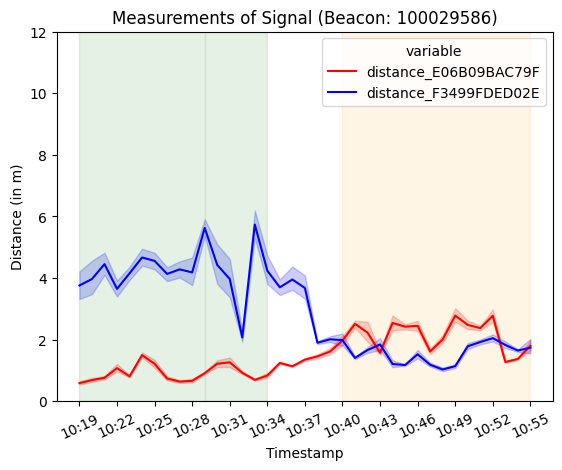

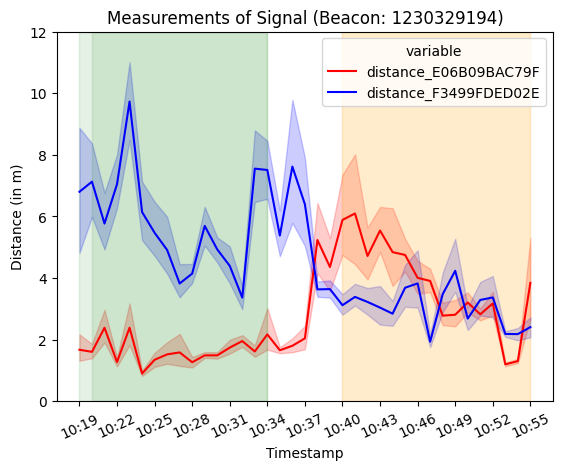

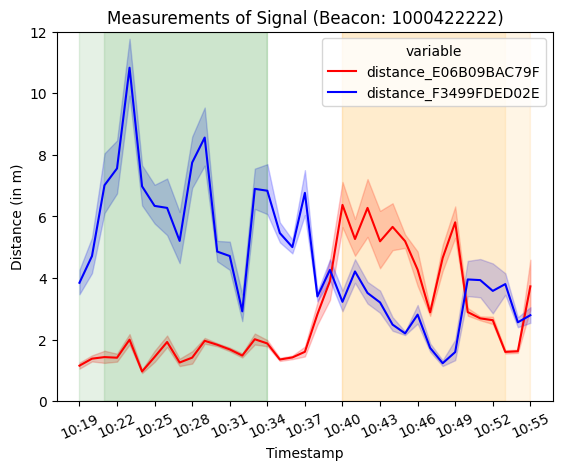

In [ ]:

for majorminor in adapted_master_df.majorminor.unique():
  df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor,(distance_column_names + ['timestamp'])]

  #Preparation for fill between values to show which measurement belongs to which room
  room1_start_timestamp = df.timestamp.min()
  room1_start_time = pd.to_datetime(room1_start_timestamp,unit='s').strftime('%H:%M')
  #5 measures a 3 minutes in room1 added to starttimestamp to get endtimestamp (60 is used for convertion to seconds)
  room1_end_timestamp = room1_start_timestamp + 5*3*60
  room1_end_time = pd.to_datetime(room1_end_timestamp,unit='s').strftime('%H:%M')
  #2 measures a 3 minutes in corridor (added to end timestamp of room1 to get starttime of room2)
  room2_start_timestamp = room1_end_timestamp + 2*3*60
  room2_start_time = pd.to_datetime(room2_start_timestamp,unit='s').strftime('%H:%M')
  #5 measures a 3 minutes in room2 added to starttimestamp to get endtimestamp (60 is used for convertion to seconds)
  room2_end_timestamp = room2_start_timestamp + 5*3*60
  room2_end_time = pd.to_datetime(room2_end_timestamp,unit='s').strftime('%H:%M')

  #Convertion of timestamp to datetime in hours and minutes for plot readability
  df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')

  #Melt of dataframe for easy plotting preparation
  melted_df = pd.melt(df, ['timestamp'])

  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=melted_df,
                    palette=['red', 'blue'])
                    #estimator='median')
                      
  ax.set(xlabel='Timestamp',
         ylabel='Distance (in m)',
         ylim=[0,12])

  #Adaptation of x label frequency to 3 minutes itteration for readability of visualisation
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

  #Filling for Room1
  ax.fill_between(melted_df.timestamp, 0,1, where=((melted_df.timestamp >= room1_start_time) & (melted_df.timestamp <= room1_end_time)),
                  color='green', alpha=0.05, transform=ax.get_xaxis_transform())

  #Filling for Room2
  ax.fill_between(melted_df.timestamp, 0,1, where=((melted_df.timestamp >= room2_start_time) & (melted_df.timestamp <= room2_end_time)),
                  color='orange', alpha=0.05, transform=ax.get_xaxis_transform())

  
  plt.title(f'Measurements of Signal (Beacon: {majorminor})')
  plt.show()

#Dateneinlesen und -grobaufbereitung
In diesem Abschnitt werden die Daten so aufbereitet, dass diese auf die Modelle angewendet werden können. Sowohl als Trainings- und Testdaten.  

In [ ]:
majorminor_to_beacon_model = {100029571:'K8', 100029586: 'K8',
                              1000411111:'Axaet PC023',
                              1000422222:'Axaet PC038',
                              1000454480:'Axaet PC061',
                              100656666:'Feasy P103', 1230329194:'Feasy P103'}

majorminor_to_manufacturer = {100029571:'K8', 100029586: 'K8',
                              1000411111:'Axaet', 1000422222:'Axaet', 1000454480:'Axaet',
                              100656666:'Feasy', 1230329194:'Feasy'}

helper = pd.Series(np.unique(list(majorminor_to_beacon_model.values())))
code_to_beacon_model = dict(zip(helper,helper.astype("category").cat.codes))

helper = pd.Series(np.unique(list(majorminor_to_manufacturer.values())))
code_to_manufacturer = dict(zip(helper,helper.astype("category").cat.codes))

In [ ]:
#Required to reconvert category code (dictionary values) to their initial name / value (dictionary keys)
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys
    return None

In [ ]:
def add_model_and_manufactorer_to_df(data_df):
  data_df['beacon_model'] = [code_to_beacon_model.get(majorminor_to_beacon_model.get(majorminor)) for majorminor in data_df.majorminor]
  data_df['manufacturer'] = [code_to_manufacturer.get(majorminor_to_manufacturer.get(majorminor)) for majorminor in data_df.majorminor]

  return data_df.copy()

In [ ]:
#Mapping used to adapt the current tags with new labels ('InRoom': True / False)
gateway_to_tag = {'E06B09BAC79F':'Room1', 'F3499FDED02E':'Room2'}

def extend_df_with_label(data_df):
  '''
  Gets dataframe and adds label to it.
  If df entry contains following values InRoom is set to 1:
  'E06B09BAC79F':'Room1' -> InRoom = 1
  'F3499FDED02E':'Room2' -> InRoom = 1
  Else -> InRoom = 0
  '''
  data_df.distance = data_df.distance.round(3)
  data_df['InRoom'] = [1 if (gateway_to_tag.get(gateway) == tag) else 0 for tag in data_df.tag]
  data_df = add_model_and_manufactorer_to_df(data_df)
  return data_df.copy()

In [ ]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
columns_of_interessts = ['distance','gateway','uuid','majorminor','timestamp','tag','specificTag']

#Create new master dicitonary seperated by gateways
master_dict = dict()

#Training
filepath = f'{root_path}IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv'
#Test closed Doors
#filepath = f'{root_path}IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
#filepath = f'{root_path}IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'

#Load and secure clean data
master_df = pd.read_csv(filepath).drop_duplicates().reset_index(drop=True)

#Load Gateways
gateways = master_df.gateway.unique()

for gateway in gateways:
  temp_df = master_df.loc[master_df.gateway == gateway].copy()
  master_dict[gateway] = {'data': pd.DataFrame()}
  master_dict[gateway]['data'] = extend_df_with_label(temp_df)

#Datenfilterung, -aufbereitung und non Machine Learning Ansatz
Dieser Abschnitt beinhalted die Funktionen und Informationen für die Datenaufbereitung. Diese werden unter anderem für die darauffolgenden Visualisierungen genutzt um zu prüfen ob eine non ML Lösung möglich ist.

In [ ]:
distance_raw = 'distance'
distance_moving_median = 'distance_MMedian'
distance_moving_mean = 'distance_MMean'
distance_wiener = 'distance_Wiener'
distance_kalman = 'distance_Kalman'

dict_filter_distance_columns = {'Raw':distance_raw, 'MMedian': distance_moving_median, 'MMean': distance_moving_mean,
                                'Wiener': distance_wiener, 'Kalman': distance_kalman}

In [ ]:
def extend_data_with_filtered_values(data_df, window_size=10):
  '''
  Gets dataframe and extends it with filter values (additional columns).
  The function is only used for analytical purposes as once optimal combinations are found
  filter should directly be applied to distance and no additional column is added to dataframe.
  @params window_size defines how many measurements are used for filter application (default 10)
  '''
  temp_df = data_df.copy()
  for majorminor in temp_df.majorminor.unique():
    distance = temp_df.loc[(temp_df.majorminor == majorminor)].distance
    #Moving Median filter
    array_distance_moving_median = distance.rolling(window=window_size,center=True).median().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_median] = array_distance_moving_median.round(3)
    #Sliding Window / moving mean filter
    array_distance_moving_mean = distance.rolling(window=window_size,center=True).mean().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_mean] = array_distance_moving_mean.round(3)
  
    #Wiener Filter
    array_distance_wiener = wiener(distance.to_numpy(),mysize=window_size)
    temp_df.loc[(temp_df.majorminor == majorminor), distance_wiener] = array_distance_wiener.round(3)
  
    #Kalman filter
    #Uses standard setting and EM algorithmen to optimize em variables such as via .em function
    #transition_covariance, observation_covariance, initial_state_mean and initial_state_covariance
    kf = KalmanFilter()
    #n_iter prevents overfitting of EM fitting and smooth predicts rssi values
    #[0][:,0] selects the predicted rssi values of the returned array
    array_distance_kalman = kf.em(distance, n_iter=5).smooth(distance)[0][:,0]
    temp_df.loc[(temp_df.majorminor == majorminor), distance_kalman] = array_distance_kalman.round(3)
  return temp_df

In [ ]:
for gateway in master_dict.keys():
  master_dict[gateway]['data'] = extend_data_with_filtered_values(data_df = master_dict[gateway]['data'])

divide by zero encountered in true_divide


#Visualisierung der Datenaufbereitung **(Optional)**

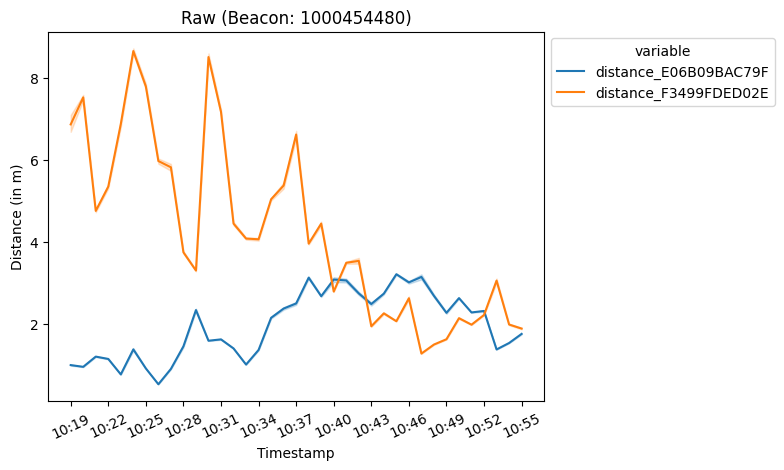

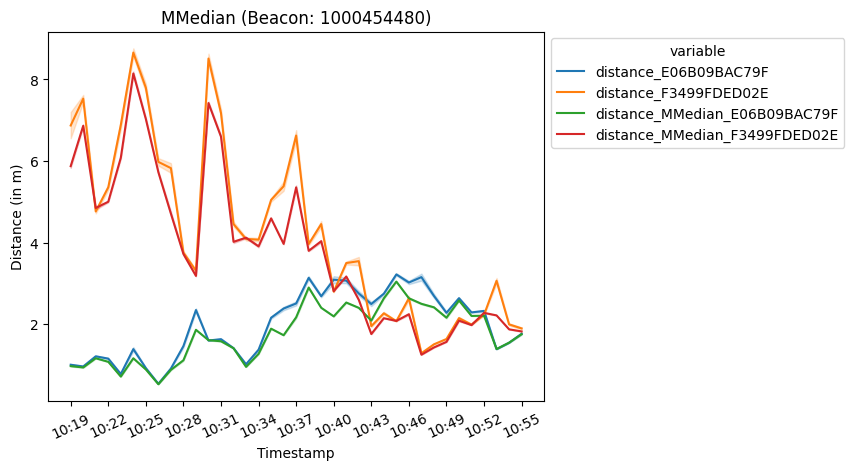

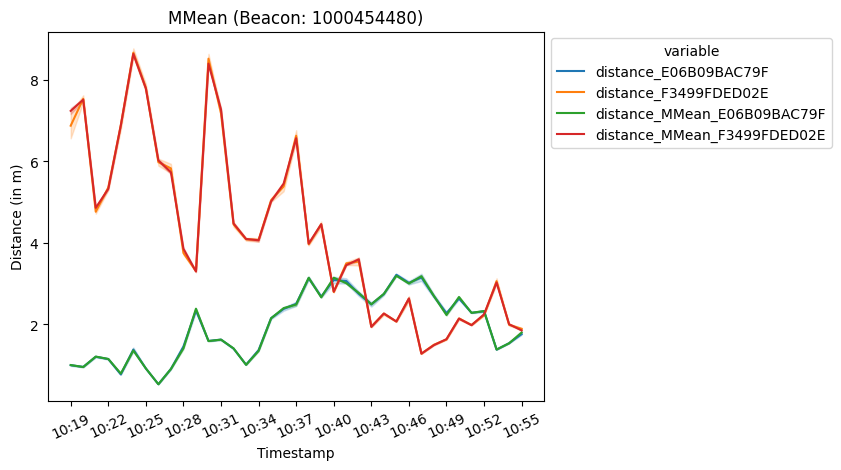

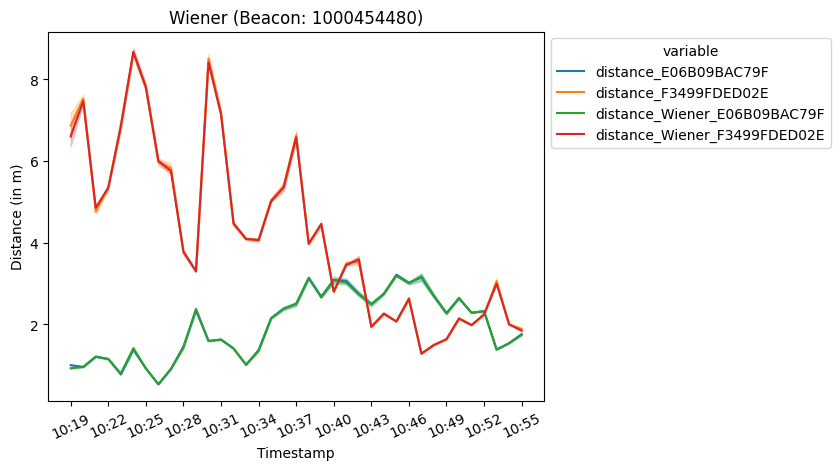

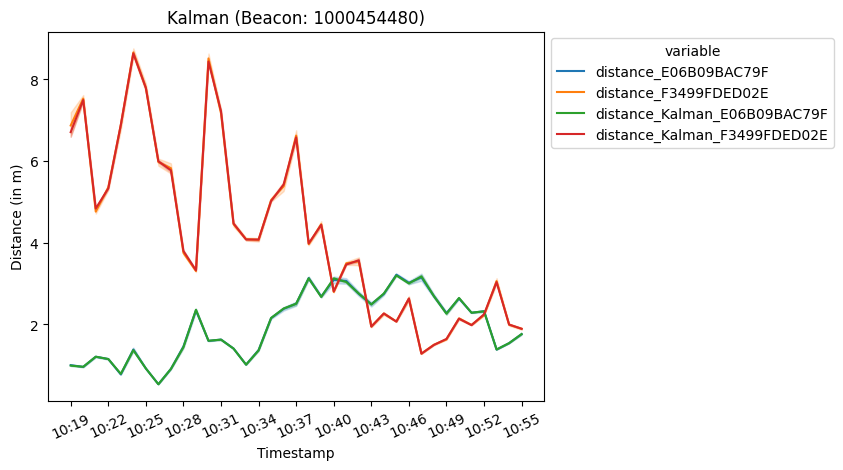

In [ ]:
#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = 1000454480 #master_df.majorminor.unique()[0]

for filter in dict_filter_distance_columns.keys():
  #Predefine column selection for plots
  column_selection = ['distance'] + [dict_filter_distance_columns.get(filter)] + ['timestamp']
  df = pd.DataFrame(columns=column_selection)
  for gateway in master_dict.keys():
    #Load data
    temp_df = master_dict.get(gateway).get('data').copy()
    #Reducing entry for specified majorminor and columns
    temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
    #Casting timestamp to a certain format for illustration
    temp_df.timestamp = pd.to_datetime(temp_df.timestamp,unit='s').dt.strftime('%H:%M')
    #Preparation for different naming in plot
    temp_df = temp_df.rename(columns={c: f'{c}_{gateway}' for c in temp_df.columns if c.startswith('distance')})
    if len(df) > 0:
      df = pd.merge(temp_df, df,on=['timestamp'],how='outer')
    else:
      df = temp_df
  #Used for df mutation for direct polting
  df = pd.melt(df, ['timestamp']).sort_values(['timestamp','variable'])
  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=df)
  #Setting three minutes jumps in timestamp and other stylings on x-axies 
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
  ax.set(xlabel='Timestamp',
         ylabel='Distance (in m)')

  plt.title(f'{filter} (Beacon: {selected_majorminor})')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.show()


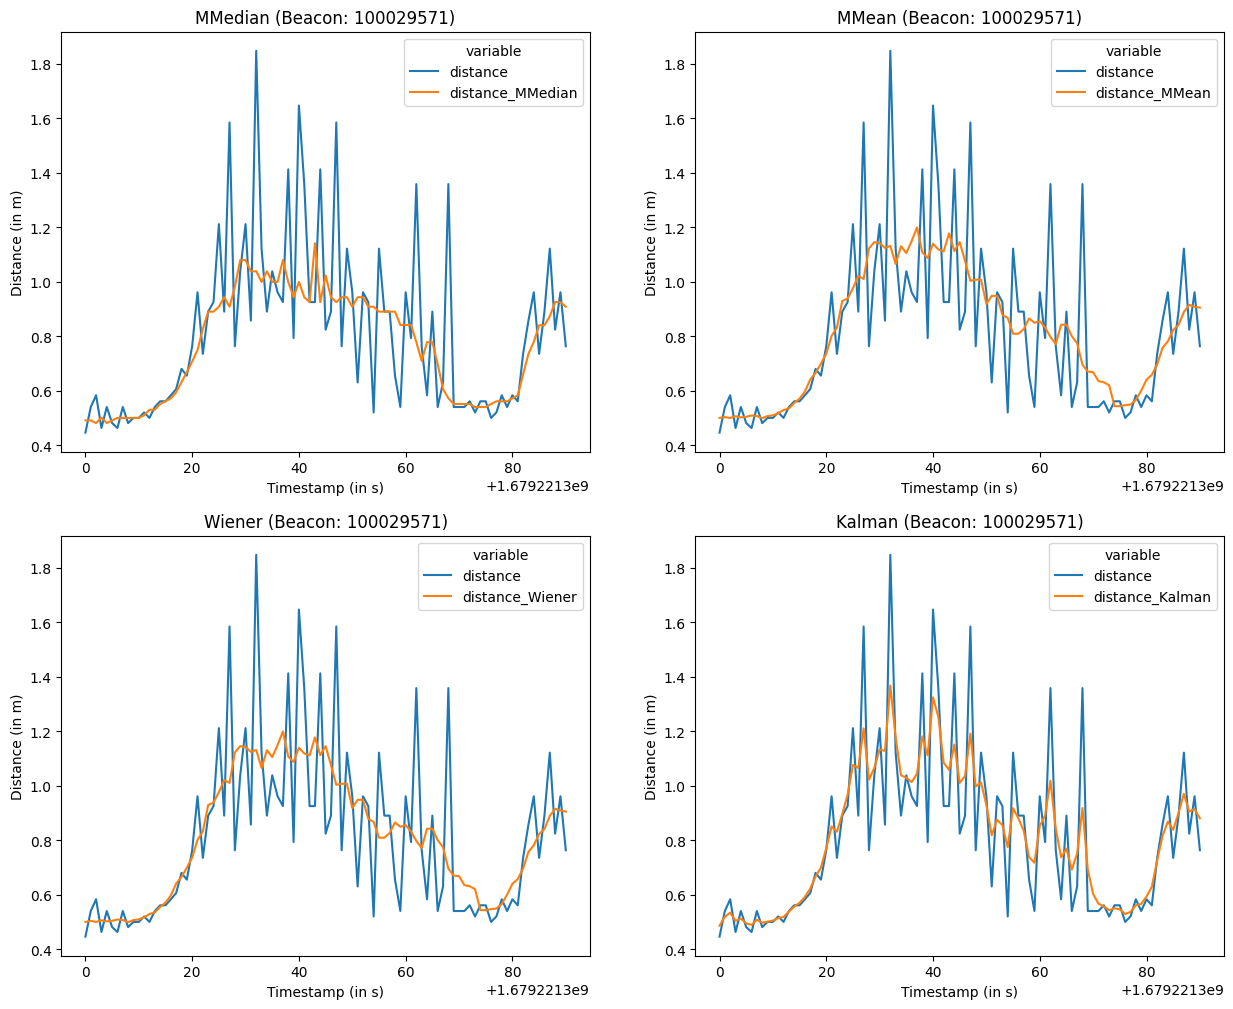

In [ ]:
#Create plot and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[1]
row_index = 0
col_index = 0

for filter in dict_filter_distance_columns.keys():
  if filter == 'Raw':
    continue
  
  if col_index / 2 >= 1:
    col_index = 0
    row_index += 1
  
  #Predefine column selection for plots
  column_distance_selection = ['distance'] + [dict_filter_distance_columns.get(filter)]
  column_selection = column_distance_selection + ['timestamp']
  df = pd.DataFrame(columns=column_selection)
  #Plot is for visualisation purposes and just a single gateway signal is required
  gateway = list(master_dict.keys())[0]

  #Load data
  temp_df = master_dict.get(gateway).get('data').copy()
  #Start time for analyisation (1 Minute after first timestamp)
  mintime = temp_df.timestamp.min() + 120

  maxtime = mintime + 90
  #Reducing entry for specified majorminor and columns
  temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
  temp_df = temp_df.loc[(temp_df.timestamp >= mintime) & (temp_df.timestamp <= maxtime)]

  df = pd.melt(temp_df, ['timestamp']).sort_values(['timestamp','variable'])
  axs[row_index,col_index] = sns.lineplot(x='timestamp', y='value', hue='variable', 
                            data=df, ax=axs[row_index,col_index])

  axs[row_index,col_index].set(xlabel='Timestamp (in s)',
                 ylabel='Distance (in m)')
  axs[row_index,col_index].set_title(f'{filter} (Beacon: {selected_majorminor})')
  col_index += 1

plt.show()

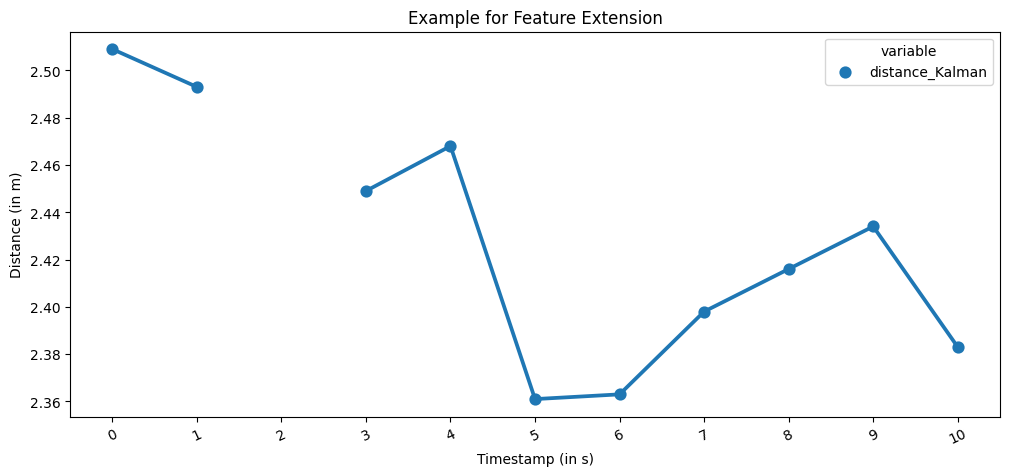

<Figure size 2000x400 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(figsize=(12,5))

#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[1]
  
#Predefine column selection for plots
column_distance_selection = ['distance_Kalman']
column_selection = column_distance_selection + ['timestamp']
df = pd.DataFrame(columns=column_selection)
#Plot is for visualisation purposes and just a single gateway signal is required
gateway = list(master_dict.keys())[0]

#Load data
temp_df = master_dict.get(gateway).get('data').copy()
#Start time for analyisation (1 Minute after first timestamp)
mintime = temp_df.timestamp.min() + 1920

maxtime = mintime + 10
#Reducing entry for specified majorminor and columns
temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
temp_df = temp_df.loc[(temp_df.timestamp >= mintime) & (temp_df.timestamp <= maxtime)]

temp_df['timestamp'] = temp_df.timestamp - mintime
temp_df.loc[temp_df.timestamp == 2,['distance_Kalman']] = np.nan
df = pd.melt(temp_df, ['timestamp']).sort_values(['timestamp','variable'])
ax = sns.pointplot(x='timestamp', y='value', hue='variable', data=df, ax=axs)

#Setting three minutes jumps in timestamp and other stylings on x-axies 
ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
ax.set(xlabel='Timestamp (in s)',
       ylabel='Distance (in m)')

plt.title(f'Example for Feature Extension')
plt.figure(figsize=(20,4))

plt.show()

#Featureerweiterung (Feature Extraction)
In diesem Abschnitt werden aus den bestehenden Daten Features generiert. Dies soll ermöglichen, dass nicht nur ein Distanzeintrag an das Modell gesendet wird. So wird die Featureanzahl von 1 auf n erhöht.
Dabei werden verschiedene Anzahlen an zusätzlichen Features ausgetestet.

In [ ]:
#enlargement_size defines amount of additional feature values
#IMPORTANT 6 should be used as upper limit or otherwise with the current 
#dataset for training the number of datapoints has to be reduced
#Problem is, that knn distance calculation gets to complex, requires to much computing
#power (speifically RAM) which can lead to crash of the virtual google colab environmenet or
#index out of bound messages which lead to model performances of NAN as calculation gets aborted

def generate_df_with_additional_features(data_df, enlargement_size = 6):
  '''
  Requires a dataframe with distance values, timestamp and majorminor.
  It extends it with additional features.
  The additional features are the n previous measurements of the same majorminor value.
  @param enlargement_size defines how many previous measurements are added as additional feature default value is 6 
  (IMPORTANT enlargement size extends number of features by 2 times its size as previous distance and timedifference is added)
  '''
  additonal_cols = []
  timediff_cols = []
  feature_cols = list(dict_filter_distance_columns.values())
  for index in range(enlargement_size,0,-1):
    additonal_cols = additonal_cols + [f'{sub}-prev{index}' for sub in feature_cols]
    timediff_cols = timediff_cols + [f'timediff-prev{index}']

  new_df = pd.DataFrame()

  for majorminor in data_df.majorminor.unique():

    #Selects each beacon seperatly for clean data preparation
    temp_df = data_df.loc[data_df.majorminor == majorminor].copy().reset_index(drop=True)

    #Defines boundries for clean iteration through current dataframe
    lower_boundry = enlargement_size
    upper_boundry = len(temp_df)
    
    #Loops through whole dataset to add features
    for current_pos_index in range(lower_boundry,upper_boundry):
      ref_timestamp = temp_df.iloc[current_pos_index].timestamp
      ref_in_room = temp_df.iloc[current_pos_index].InRoom

      #Selects the n (enlargement_size) previous df entries before the current df entry
      df_section = temp_df.iloc[(current_pos_index - enlargement_size) : current_pos_index]

      #If Label InRoom is NOT the same it should lead to a sum of more than 0
      #in this case current iteration is skipped as it can not be used for training
      #Training should just contain previous data of the same label value
      if sum(df_section.InRoom != ref_in_room) > 0:
        continue

      #Current timestamp gets substracted of each entry seperatly
      timediffs = df_section.timestamp - ref_timestamp
      additional_features = df_section.loc[:,feature_cols]

      #Useage of col order and array transforming (reshaping) for direct assigning of values
      #As it is set for a single df entry shape has to be (n,1)
      temp_df.loc[temp_df.index == current_pos_index,timediff_cols] = timediffs.to_numpy().T
      temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = additional_features.to_numpy().reshape(len(additonal_cols))       
        

      ##'Simpler' solution but extremly imperformant
      ##Above solution is 7 times faster

      #for index in range(1,enlargement_size+1):
        
      #  additional_features_index = current_pos_index - index
        #Abort current iteration as it should just use reference points within same label (InRoom)
      #  if (ref_in_room != temp_df.iloc[additional_features_index].InRoom):
      #    continue
      #  timediff = temp_df.iloc[additional_features_index].timestamp - ref_timestamp
        
      #  additonal_cols = [sub +'-prev'+str(index) for sub in feature_cols]
      #  distances = temp_df.loc[temp_df.index == additional_features_index,feature_cols]

      #  temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = distances.to_numpy()
      #  temp_df.loc[temp_df.index == current_pos_index,['timediff-prev'+str(index)]] = timediff

    #Cleans df and drops all rows which contain a single nan value
    temp_df = temp_df.dropna()
    #Checks if df has already entries and has to be concated with them or new assigned
    if len(new_df) > 0:  
      new_df = pd.concat([new_df, temp_df], ignore_index=True)
    else:
      new_df = temp_df.copy()
  return new_df.copy()

In [ ]:
for gateway in master_dict.keys():
  df = master_dict.get(gateway).get('data')
  master_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = df)

#Benötigte Funktionen für weitere Schritte (Datenselektionierung)
Es beinhaltet Funktionen, welche für das RNN / LSTM Modell wichtig sind.
Aber auch die X und y Selektion für die anderen Modelle. Muss damit nicht optionale Schritte funktionieren ausgeführt werden.

In [ ]:
#Preceeding sequence for RNN / LSTM
#Global Variable required for sequence length
#Used for sequential models (currently RNN / LSTM model only).
SEQ_LEN = 60

In [ ]:
def balance_sequence_data(sequential_data):
  '''
  Function to balance the number of data used for each class.
  Ensures that amount is equal for each class.
  Used for sequential models (currently RNN / LSTM model only).
  '''
  #List containing sequeces seperated by label value
  in_room = []
  out_of_room = []

  for seq, InRoom in sequential_data:
    if InRoom == 0:
      out_of_room.append([seq, InRoom])
    elif InRoom == 1:
      in_room.append([seq, InRoom])

  #Randomize order as structural info are already in sequences itself
  random.shuffle(in_room)
  random.shuffle(out_of_room)

  lower = min(len(in_room), len(out_of_room))

  #Ensure equal distribution of labeled data
  return in_room[:lower] + out_of_room[:lower]

In [ ]:
def preprocess_df(df, shuffle_data = True, balance_data = False):
  '''
  Additional extension of sequential context as timeseries info is not added to.
  Required for sequential models (currently RNN / LSTM model only).
  '''
  #List that contains the sequences but is not the sequence itself
  sequential_data = []
  #Actual sequence which will contain the current sequence and loose last value if max size is reached and new value is added
  prev_measurements = deque(maxlen=SEQ_LEN)

  for i in df.values:
    prev_measurements.append([n for n in i[:-1]])
    #Only store current sequence if SEQ_LEN is reached / current sequence is full
    if len(prev_measurements) == SEQ_LEN:
      sequential_data.append([np.array(prev_measurements), i[-1]])

  if balance_data == True:
    sequential_data = balance_sequence_data(sequential_data)

  if shuffle_data == True:
    random.shuffle(sequential_data)

  X = []
  y = []

  for seq, InRoom in sequential_data:
    X.append(seq)
    y.append(InRoom)
  if shuffle_data == True:
    return shuffle(X, y)
  else:
    return X, y

In [ ]:
def get_seperated_X_y(df, filter, model_type, shuffle_data = True):
  '''
  Seperates given dataframe into X and y.
  Dataframe has to be the dataframe which contains all information and is not already reduced
  to only containing the features and label.
  The function returns the data separated by feature and label
  '''
  prefix = str(dict_filter_distance_columns.get(filter))
  column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
  extended_column_selection = column_selection + ['beacon_model'] #['manufacturer']

  if model_type == 'rnn':
    X_List = []
    y_List = []    

    for majorminor in df.majorminor.unique():
      data = df.loc[df.majorminor == majorminor,extended_column_selection+['InRoom']]
      X_part, y_part = preprocess_df(data, shuffle_data)
      #Unpacks list and combines them to one
      X_List = [*X_List, *X_part]
      y_List = [*y_List, *y_part]

    X = np.array(X_List)
    y = np.array(y_List)
    if shuffle_data == True:
      X, y = shuffle(X, y)

  else:
    X = df.loc[:,extended_column_selection]
    y = df.InRoom

  return X, y

#Grosse Trainingsdatenansammlung zusammenstellen **(Optional)**
Kombination der im Trainigsordner enthaltenen gelabelten / getaggten Daten.
Auf diese werden noch jeweils einzeln die Filteroptionen und Feature Extension angewendet.

In [ ]:
path = f'{root_path}IndoorTrackingML/DATA/Training/Complete_Data'

os.chdir(path)

master_train_dict = dict()

for csv_file in glob.glob('*.csv'):
  print(csv_file)
  full_path = f'{path}/{csv_file}'
  current_df = pd.read_csv(full_path).drop_duplicates().reset_index(drop=True)

  for gateway in current_df.gateway.unique():
    temp_df = current_df.loc[current_df.gateway == gateway].copy()
    temp_df = extend_df_with_label(data_df = temp_df)
    temp_df = extend_data_with_filtered_values(data_df = temp_df)
    extended_temp_df = generate_df_with_additional_features(data_df = temp_df)

    if master_train_dict.get(gateway) is None:
      master_train_dict[gateway] = {'extended_data': extended_temp_df}

    else:
      new_extended_data = pd.concat([master_train_dict[gateway].get('extended_data'), extended_temp_df], ignore_index=True)
      master_train_dict[gateway]['extended_data'] = new_extended_data.copy()


In [ ]:
path = f'{root_path}IndoorTrackingML/DATA/Training/'

for gateway in master_train_dict.keys():
  temp_df = master_train_dict[gateway].get('extended_data')
  temp_df.to_csv(r''+path+f'/Master_Train_Df_{gateway}.csv', index=False)

#Laden des erweiterten Trainingsdatensatz
Ladet das im oberen erstellte File mit allen Trainingsdatensätzen. Der obere Abschnitt muss so nur ausgeführt werden, wenn neue Trainingsdatensätze hinzukommen und fürs Training beachtet werden soll.

In [ ]:
path = f'{root_path}IndoorTrackingML/DATA/Training/'

os.chdir(path)

master_train_dict = dict()

for csv_file in glob.glob('*.csv'):
  full_path = f'{path}/{csv_file}'
  current_df = pd.read_csv(full_path).drop_duplicates().reset_index(drop=True)

  gateway = current_df.gateway[0]
  master_train_dict[gateway] = {'extended_data': current_df}

#Machine Learning Algorithmen Training / Hyperparameter Tuning  **(Optional)**
Beinhaltet die unterschiedlichen Machine Learning Ansätze, welche auf die Trainingsdatensätze Hyperparameter Tuning durchgeführt wird.

KNN, Naive Bayes, Support Vector Classifier (SVC), Random Forest Classifier und XGBoost

In [ ]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times
random_state=42
dict_best_accuracy = dict.fromkeys(master_dict.keys(), {})



In [ ]:
#Initial entry for RNN / LSTM model as step by RNN / LSTM model is only a setup and accuracy entry would be missing
model_type = 'rnn'

for gateway in master_dict.keys():
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

##Nearest Neighbors Classifier

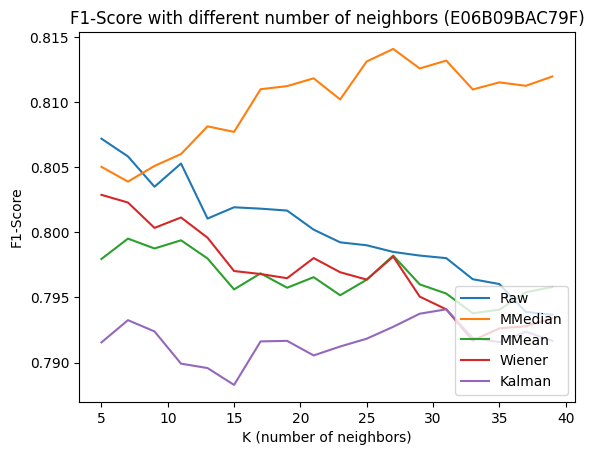

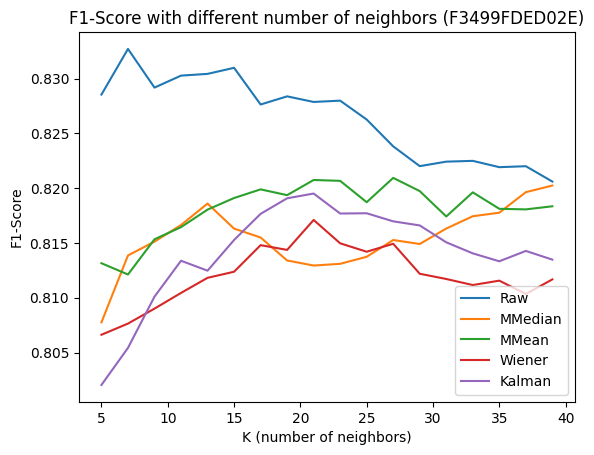

In [ ]:
model_type = 'knn'

for gateway in master_dict.keys():
  #Loads limited amount of data due to errors (Session break downs and nan scoring values)
  #Required if additional feature extends 6 
  df = master_dict.get(gateway).get('extended_data')#.sample(20000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_accuracy = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  k = []

  #Check different number of neighbors
  for n_neighbors in range(5, 40, 2):
    #Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    k.append(n_neighbors)

    for filter in dict_filter_distance_columns.keys():
      prefix = dict_filter_distance_columns.get(filter)
      column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]

      X = df.loc[:,column_selection]
      Y = df.InRoom

      #Ensures that folds are shuffled to prevent overfitting
      kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

      #Calculates cross validation score 
      crossv_results = cross_val_score(knn, X, Y, cv=kfold, scoring='f1_weighted')

      #Append score to list categorised by filter for easy plotting
      dict_accuracy[filter] = dict_accuracy.get(filter) + [crossv_results.mean()]

      #Checks if the current k for the knn model with the given data (provided by a certain gateway and applied filter) is better than the previous model performance
      #if this is the case the current settings overwrite the previous settings
      if (len(dict_best_accuracy[gateway][model_type][filter])==0) or (dict_best_accuracy[gateway][model_type][filter]['best_score_'] < [crossv_results.mean()]) :
        dict_best_accuracy[gateway][model_type][filter] = {'best_score_': crossv_results.mean(),
                                    'best_params_': {'n_neighbors': n_neighbors}}
  #Used for ploting a graph which shows the performance of the models
  #depending on number of neighbors with the given training / test data
  for key in dict_accuracy.keys():
    plt.plot(k, dict_accuracy[key])
  plt.ylabel('F1-Score')
  plt.xlabel('K (number of neighbors)')
  plt.legend(dict_accuracy.keys(), loc='lower right')
  plt.title(f'F1-Score with different number of neighbors ({gateway})')
  plt.show()

##Support Vector Classification (SVC)

In [ ]:
model_type = 'svc'

#Define values of parameters to test for optimize model
#The reduced number of options in the parameters is due to several
#executions in which required options could be narrowed down
param_svc_grid = { 'C': [10, 100], 'gamma': [1, 0.1], 'kernel': ['rbf'] }

for gateway in master_dict.keys():
  #Loads data with additional features
  #Sample can be used if hypertuning time should be reduced (Could lead to not optimal hyperparameter)
  df = master_dict.get(gateway).get('extended_data')#.sample(8000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of support vector classification model
  #Some default parameter values are changed in grid search further below by param_svc_grid above
  svc = SVC()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    
    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    svc_grid = GridSearchCV(estimator=svc, param_grid=param_svc_grid, cv=kfold, scoring='f1_weighted')
    #RandomizedSearchCV(estimator=svm, param_grid=param_svc_grid, cv=kfold, random_state=random_state, n_iter=10)
    svc_grid.fit(X, Y)

    print(filter)
    print(svc_grid.best_score_)
    print(svc_grid.best_params_)
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': svc_grid.best_score_,
                                                       'best_params_': svc_grid.best_params_}

E06B09BAC79F
Raw
0.8143510519386279
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
MMedian
0.8183480854250554
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
MMean
0.7980459787020567
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Wiener
0.7991075546124164
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Kalman
0.7946895031983228
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
F3499FDED02E
Raw
0.8278336731833151
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
MMedian
0.8238759327129396
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
MMean
0.8232957234605156
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Wiener
0.8141724197804946
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Kalman
0.8129692542046634
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


##Naive Bayes

In [ ]:
model_type = 'nbayes'

#Define values of parameters to test for optimize model
param_grid_nb = { 'var_smoothing': np.logspace(0,-9, num=100) }

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data')

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of gaussian naive bayes classifier model
  #Some default parameter values are changed in grid search further below by param_grid_nb above
  gnb = GaussianNB()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['beacon_model']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    gnb_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=kfold, scoring='f1_weighted')
    gnb_grid.fit(X, Y)

    print(filter)
    print(gnb_grid.best_score_)
    print(gnb_grid.best_params_)
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': gnb_grid.best_score_,
                                                       'best_params_': gnb_grid.best_params_}

E06B09BAC79F
Raw
0.6864361548951814
{'var_smoothing': 0.0001519911082952933}
MMedian
0.742516442958369
{'var_smoothing': 0.0005336699231206307}
MMean
0.7202968593112583
{'var_smoothing': 4.328761281083062e-05}
Wiener
0.7135339399226408
{'var_smoothing': 1.5199110829529332e-05}
Kalman
0.721241616007469
{'var_smoothing': 0.0001}
F3499FDED02E
Raw
0.7423527416338767
{'var_smoothing': 0.0023101297000831605}
MMedian
0.7885031417542814
{'var_smoothing': 0.0001232846739442066}
MMean
0.7750208606049165
{'var_smoothing': 0.0001232846739442066}
Wiener
0.7691013041252373
{'var_smoothing': 0.0005336699231206307}
Kalman
0.7750501022059264
{'var_smoothing': 6.579332246575683e-05}


##Random Forest

In [ ]:
#Define space required for bayesian optimization (is an alternativ to GridSearchCV and RandomizedSearchCV)
#This approach as well as RandomizedSearchCV is usefull if number of possible params combination is high

#Number of trees in random forest that are used for estimation
n_estimators = range(100,501,100)
#Number of features to consider at every split
max_features = ['sqrt'] #Excluded 'auto' as it is deprecated in 1.1 and will be removed in 1.3
#Maximum number of levels in tree
max_depth = range(15,21,5)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
#Method of selecting samples for training each tree
bootstrap = [True, False]

space_rforest = {
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'max_features': hp.choice('max_features', max_features),
    'max_depth' : hp.choice('max_depth', max_depth),
    'min_samples_split' : hp.choice('min_samples_split', min_samples_split),
    'min_samples_leaf' : hp.choice('min_samples_leaf', min_samples_leaf),     
    'bootstrap' : hp.choice('bootstrap', bootstrap)
}

#Defines maximal evaluations which are run via bayesian optimization
#The higher the value the more time fitting will require
max_evals = 40

In [ ]:
#Objective function required for bayesian optimization
def objective_rforest(params):
  #Ensures that folds are shuffled to prevent overfitting
  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)
  #Creates random forest classifier with given random_state to ensure replication of result and params for trial
  rforest = RandomForestClassifier(random_state=random_state, **params)
  score = cross_val_score(estimator=rforest,
                          X=X, 
                          y=Y, 
                          cv=kfold, 
                          scoring='f1_weighted', 
                          n_jobs=-1).mean()
  #Loss is negative score (required as fmin tries to minimize the score)
  loss = -score
  #Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
model_type = 'rforest'

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data')#.sample(10000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  
  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['beacon_model']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Defines trials which is used for documenation of each trial in fmin function
    #it is externally declareted to extract the best loss score further below
    trials = Trials()
    #fmin is a bayesian optimization based function of hyperopt, it searches for the optimal parameters
    #to minimize the loss score
    best_params_index = fmin(fn = objective_rforest, space = space_rforest, algo = tpe.suggest, max_evals = max_evals, trials = trials)

    #Exchange index of parameters with values defined in space
    best_params_ = space_eval(space_rforest, best_params_index)
    
    #Select best / lowest loss score as the closer to -1 the better performance the model has on the given data 
    #multiplication by -1 is required to convert to positiv score 
    best_score_ = min(trials.losses()) * (-1)

    print(filter)
    print(best_score_)
    print(best_params_)
    #Stores result in dictionary seperated by gateway, model and filter
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': best_score_,
                                                       'best_params_': best_params_}

E06B09BAC79F
100%|██████████| 40/40 [03:17<00:00,  4.94s/trial, best loss: -0.8951205155904592]
Raw
0.8951205155904592
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
100%|██████████| 40/40 [02:28<00:00,  3.71s/trial, best loss: -0.9029814268237606]
MMedian
0.9029814268237606
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
 15%|█▌        | 6/40 [00:39<03:09,  5.58s/trial, best loss: -0.8880818267838393]

##XG Boost

In [ ]:
#Define space required for bayesian optimization (is an alternativ to GridSearchCV and RandomizedSearchCV)
space_xgboost = {
    'learning_rate' : hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(15,21,5)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

#Defines maximal evaluations which are run via bayesian optimization
#The higher the value the more time fitting will require
max_evals = 40

In [ ]:
#Objective function required for bayesian optimization
def objective_xgboost(params):
  #Ensures that folds are shuffled to prevent overfitting
  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)
  #Creates XGBoost Classifier with given seed to ensure replication of result and params
  #for trial
  xgboost = XGBClassifier(seed=random_state, **params)
  score = cross_val_score(estimator=xgboost,
                          X=X, 
                          y=Y, 
                          cv=kfold, 
                          scoring='f1_weighted', 
                          n_jobs=-1).mean()
  #Loss is negative score (required as fmin tries to minimize the score)
  loss = -score
  #Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}
    

In [ ]:
model_type = 'xgboost'

for gateway in master_dict.keys():
  #Loads data with additional features, limited to 10'000 samples to reduce calculation time
  #for hyperparameter tuening
  df = master_dict.get(gateway).get('extended_data')#.sample(10000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['beacon_model']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Defines trials which is used for documenation of each trial in fmin function
    #it is externally declareted to extract the best loss score further below
    trials = Trials()
    #fmin is a bayesian optimization based function of hyperopt, it searches for the optimal parameters
    #to minimize the loss score
    best_params_index = fmin(fn = objective_xgboost, space = space_xgboost, algo = tpe.suggest, max_evals = max_evals, trials = trials)
    
    #Exchange index of parameters with values defined in space
    best_params_ = space_eval(space_xgboost, best_params_index)
    
    #Select best / lowest loss score as the closer to -1 the better performance the model has on the given data 
    #multiplication by -1 is required to convert to positiv score 
    best_score_ = min(trials.losses()) * (-1)
    print(filter)
    print(best_score_)
    print(best_params_)
    #Stores result in dictionary seperated by gateway, model and filter
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': best_score_,
                                                       'best_params_': best_params_}

E06B09BAC79F
100%|██████████| 40/40 [01:47<00:00,  2.69s/trial, best loss: -0.8959253285448675]
Raw
0.8959253285448675
{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 20, 'reg_alpha': 1, 'reg_lambda': 1}
100%|██████████| 40/40 [01:31<00:00,  2.30s/trial, best loss: -0.9067047703747371]
MMedian
0.9067047703747371
{'colsample_bytree': 0.3, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 20, 'reg_alpha': 1e-05, 'reg_lambda': 0.1}
100%|██████████| 40/40 [01:46<00:00,  2.67s/trial, best loss: -0.8846948119873975]
MMean
0.8846948119873975
{'colsample_bytree': 0.4, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 15, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
100%|██████████| 40/40 [02:05<00:00,  3.13s/trial, best loss: -0.8939186652959616]
Wiener
0.8939186652959616
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 20, 'reg_alpha': 0.01, 'reg_lambda': 10}
100%|██████████| 40/40 [02:02<00:00,  3.07s/trial, best loss: -0.8878363096121296]
Kalma

#RNN / LSTM Modell

In [ ]:
LABEL = 'InRoom'
#Number of times to pass through training data
EPOCHS = 30
#Size of Batch for iteration. Can be reduced if out of memory errors occur.
BATCH_SIZE = 64

In [ ]:
def compile_lstm_model(X_df):
  '''
  Requires df with x-Data to enable an adaptable length / input shape.
  As with feature extension the input shape is not fixed to a certain size and shape.
  '''
  model = Sequential()
  #Input Layer with dropout of 20%
  model.add(LSTM(64, input_shape=(X_df.shape[1:]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #Hidden Layer with dropout of 10%
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  #Hidden Layer with dropout of 20%
  model.add(LSTM(64))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #Hidden Layer main focus densitiy of layers bevor
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  #Ouput Layer
  model.add(Dense(2, activation='softmax'))

  #Define Optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

  metric = tf.metrics.F1Score(num_classes=2, average='weighted')

  #Compile model
  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=[metric]
  )

  return model

In [ ]:
def train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test):
  #Name of model / predictor
  name = f'{gateway}-Gateway-rnn-Model-{filter}-Filter'
  #Log for TensorBoard
  tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

  #Unique file name that will include the epoch and the validation acc for that epoch
  fileprefix = f'{gateway}_{filter}_'
  filepath = fileprefix + 'RNN_Final'
  #Add checkpoint but saves only the weights of the best model
  checkpoint = ModelCheckpoint('models/{}.ckpt'.format(filepath), monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
  #Add early stopping logic
  early_stopping = EarlyStopping(patience=5, min_delta=0.001, monitor="val_loss", restore_best_weights=True)

  #Train model
  history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard, checkpoint, early_stopping]
  )

  #Reloads weights of best model for evaluation
  model.load_weights('models/{}.ckpt'.format(filepath))

  #Score model
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  #Save model
  model.save("models/{}".format(name))
  return model

#Hyperparameter Tuning Zuweisung der erhobenen Erkenntnisse **(Falls Abschnitt "Machine Learning Algorithmen Training / Hyperparameter Tuning" übersprungen wird)**
Dieser Abschnitt wird genutzt um den rechen- und zeitintensiven Schritt der Hyperparameter Tuning der Modelle des vorherigen Abschnitts zu überspringen.

In [ ]:
dict_best_accuracy = {'E06B09BAC79F': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8278336731833151,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.8238759327129396,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8232957234605156,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8141724197804946,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.8129692542046634,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.0023101297000831605}},
   'MMedian': {'best_score_': 0.7885031417542814,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'MMean': {'best_score_': 0.7750208606049165,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Kalman': {'best_score_': 0.7750501022059264,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}}},
  'rforest': {'Raw': {'best_score_': 0.8915885219221152,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 400}},
   'MMedian': {'best_score_': 0.8978434927262562,
    'best_params_': {'bootstrap': False,
     'max_depth': 15,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 200}},
   'MMean': {'best_score_': 0.895936841321312,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 100}},
   'Wiener': {'best_score_': 0.8996331467817866,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 500}},
   'Kalman': {'best_score_': 0.8885509647487962,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 10,
     'n_estimators': 500}}},
  'xgboost': {'Raw': {'best_score_': 0.8932995335614413,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.2,
     'learning_rate': 0.01,
     'max_depth': 15,
     'reg_alpha': 0.1,
     'reg_lambda': 1e-05}},
   'MMedian': {'best_score_': 0.907046032867143,
    'best_params_': {'colsample_bytree': 0.4,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMean': {'best_score_': 0.8930545126072726,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 0.1}},
   'Wiener': {'best_score_': 0.8960607257680625,
    'best_params_': {'colsample_bytree': 0.8,
     'gamma': 0.4,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Kalman': {'best_score_': 0.8848042914309484,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1,
     'reg_lambda': 1}}},
  'rnn': {'Raw': {},
    'MMedian': {},
    'MMean': {},
    'Wiener': {},
    'Kalman': {}}},
 'F3499FDED02E': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8278336731833151,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.8238759327129396,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8232957234605156,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8141724197804946,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.8129692542046634,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.0023101297000831605}},
   'MMedian': {'best_score_': 0.7885031417542814,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'MMean': {'best_score_': 0.7750208606049165,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Kalman': {'best_score_': 0.7750501022059264,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}}},
  'rforest': {'Raw': {'best_score_': 0.8915885219221152,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 400}},
   'MMedian': {'best_score_': 0.8978434927262562,
    'best_params_': {'bootstrap': False,
     'max_depth': 15,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 200}},
   'MMean': {'best_score_': 0.895936841321312,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 100}},
   'Wiener': {'best_score_': 0.8996331467817866,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 500}},
   'Kalman': {'best_score_': 0.8885509647487962,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 10,
     'n_estimators': 500}}},
  'xgboost': {'Raw': {'best_score_': 0.8932995335614413,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.2,
     'learning_rate': 0.01,
     'max_depth': 15,
     'reg_alpha': 0.1,
     'reg_lambda': 1e-05}},
   'MMedian': {'best_score_': 0.907046032867143,
    'best_params_': {'colsample_bytree': 0.4,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMean': {'best_score_': 0.8930545126072726,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 0.1}},
   'Wiener': {'best_score_': 0.8960607257680625,
    'best_params_': {'colsample_bytree': 0.8,
     'gamma': 0.4,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Kalman': {'best_score_': 0.8848042914309484,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1,
     'reg_lambda': 1}}},
  'rnn': {'Raw': {},
    'MMedian': {},
    'MMean': {},
    'Wiener': {},
    'Kalman': {}}}}

#Test Daten laden und aufbereiten

In [ ]:
#Test closed Doors
filepath_test_closed_door = f'{root_path}IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
filepath_test_open_door = f'{root_path}IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'

#Load and secure clean data
test_open_door_df = pd.read_csv(filepath_test_open_door).drop_duplicates().reset_index(drop=True)
test_closed_door_df = pd.read_csv(filepath_test_closed_door).drop_duplicates().reset_index(drop=True)

test_open_door_dict = dict()
test_closed_door_dict = dict()

#Load Gateways
gateways = test_open_door_df.gateway.unique()

for gateway in gateways:
  temp_open_df = test_open_door_df.loc[test_open_door_df.gateway == gateway].copy()
  temp_open_df = extend_df_with_label(data_df = temp_open_df)
  temp_open_df = extend_data_with_filtered_values(data_df = temp_open_df)
  test_open_door_dict[gateway] = {'data': temp_open_df.copy()}
  test_open_door_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = temp_open_df)

  temp_closed_df = test_closed_door_df.loc[test_closed_door_df.gateway == gateway].copy()
  temp_closed_df = extend_df_with_label(data_df = temp_closed_df)
  temp_closed_df = extend_data_with_filtered_values(data_df = temp_closed_df)
  test_closed_door_dict[gateway] = {'data': temp_closed_df.copy()}
  test_closed_door_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = temp_closed_df)

#Fitting der Modelle und Vorbereitung für Auswertung **(Optional)**

In [ ]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times (Repli)
random_state=42

In [ ]:
#Sets save path for models to root path
path = f'{root_path}IndoorTrackingML/'
os.chdir(path)

for gateway in dict_best_accuracy.keys():
  df = master_train_dict[gateway].get('extended_data')
  print('Gateway: '+gateway)
  for model_type in dict_best_accuracy[gateway].keys():
    print('\tModel type: '+model_type)
    for filter in dict_best_accuracy[gateway][model_type].keys():
      #Loads params that lead to best performance in hyperparameter tuening
      params = dict_best_accuracy[gateway][model_type][filter].get('best_params_')
      #if else is used as current python version of notebook does not support match case (swith case)
      if model_type == 'knn':
        #** is used to unpack dictionary of params 
        #it is required so that every param gets recognised and mapped to the
        #specific function parameters
        model = KNeighborsClassifier(**params)
      elif model_type == 'svc':
        model = SVC(**params, probability = True)
      elif model_type == 'nbayes':
        model = GaussianNB(**params)
      elif model_type == 'rforest':
        model = RandomForestClassifier(random_state=random_state, **params)
      elif model_type == 'xgboost':
        model = XGBClassifier(seed=random_state, **params)
      elif model_type == 'rnn':
        #Due to complexity and difference in data preparation
        #rnn gets prepared seperatly
        continue
      else:
        print(f'Model ({model_type}) not definied')
        continue

      X_train, y_train = get_seperated_X_y(df, filter, model_type)

      model.fit(X_train,y_train)

      name = f'{gateway}-Gateway-{model_type}-Model-{filter}-Filter'
      #Saves model as compressed file on current selected os path
      joblib.dump(model, "models/{}".format(name), compress=3)

      #Fitted model is added to dictionary
      dict_best_accuracy[gateway][model_type][filter]['model'] = model

Gateway: E06B09BAC79F
	Model type: knn
	Model type: svc


In [ ]:
#Seperate Training logic to other ml as required preparation differ to other used models
model_type = 'rnn'

#Sets save path for models to root path (model save is done in train_lstm_model-function)
path = f'{root_path}IndoorTrackingML/'
os.chdir(path)

#Fit model for each gateway and filter options
for gateway in dict_best_accuracy.keys():
  df = master_train_dict[gateway].get('extended_data')  
  for filter in dict_filter_distance_columns.keys():
    X, y = get_seperated_X_y(df, filter, model_type)

    #Splits data and shuffles entries after they were ordered by majorminor before
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
    
    #Ensures that everything is an array as lstm requires it to be
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = compile_lstm_model(X_train)
    model = train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test)

    dict_best_accuracy[gateway][model_type][filter]['model'] = model

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.8960
Epoch 1: val_accuracy improved from -inf to 0.90894, saving model to models/E06B09BAC79F_Raw_RNN_Final.ckpt
488/488 [==============================] - 65s 118ms/step - loss: 0.2518 - accuracy: 0.8960 - val_loss: 0.1976 - val_accuracy: 0.9089
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9202
Epoch 2: val_accuracy improved from 0.90894 to 0.91689, saving model to models/E06B09BAC79F_Raw_RNN_Final.ckpt
488/488 [==============================] - 54s 111ms/step - loss: 0.1881 - accuracy: 0.9202 - val_loss: 0.1864 - val_accuracy: 0.9169
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9337
Epoch 3: val_accuracy did not improve from 0.91689
488/488 [==============================] - 54s 111ms/step - loss: 0.1546 - accuracy: 0.9337 - val_loss: 0.2094 - val_accuracy: 0.9021
Epoch 4/30
488/488 [====================

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9028
Epoch 1: val_accuracy improved from -inf to 0.88816, saving model to models/E06B09BAC79F_MMedian_RNN_Final.ckpt
488/488 [==============================] - 63s 114ms/step - loss: 0.2295 - accuracy: 0.9028 - val_loss: 0.2676 - val_accuracy: 0.8882
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9260
Epoch 2: val_accuracy improved from 0.88816 to 0.90625, saving model to models/E06B09BAC79F_MMedian_RNN_Final.ckpt
488/488 [==============================] - 53s 109ms/step - loss: 0.1785 - accuracy: 0.9260 - val_loss: 0.3001 - val_accuracy: 0.9062
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9413
Epoch 3: val_accuracy improved from 0.90625 to 0.93831, saving model to models/E06B09BAC79F_MMedian_RNN_Final.ckpt
488/488 [==============================] - 53s 110ms/step - loss: 0.1415 - accuracy: 0.9413 - val_loss

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9002
Epoch 1: val_accuracy improved from -inf to 0.91561, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
488/488 [==============================] - 65s 114ms/step - loss: 0.2443 - accuracy: 0.9002 - val_loss: 0.2094 - val_accuracy: 0.9156
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9230
Epoch 2: val_accuracy improved from 0.91561 to 0.93331, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.1883 - accuracy: 0.9230 - val_loss: 0.1579 - val_accuracy: 0.9333
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9346
Epoch 3: val_accuracy improved from 0.93331 to 0.94703, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.1574 - accuracy: 0.9346 - val_loss: 0.13

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8944
Epoch 1: val_accuracy improved from -inf to 0.92010, saving model to models/E06B09BAC79F_Wiener_RNN_Final.ckpt
488/488 [==============================] - 62s 113ms/step - loss: 0.2537 - accuracy: 0.8944 - val_loss: 0.1808 - val_accuracy: 0.9201
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9170
Epoch 2: val_accuracy improved from 0.92010 to 0.93677, saving model to models/E06B09BAC79F_Wiener_RNN_Final.ckpt
488/488 [==============================] - 52s 108ms/step - loss: 0.1963 - accuracy: 0.9170 - val_loss: 0.1539 - val_accuracy: 0.9368
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9276
Epoch 3: val_accuracy improved from 0.93677 to 0.93921, saving model to models/E06B09BAC79F_Wiener_RNN_Final.ckpt
488/488 [==============================] - 52s 108ms/step - loss: 0.1678 - accuracy: 0.9276 - val_loss: 0

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8926
Epoch 1: val_accuracy improved from -inf to 0.88560, saving model to models/E06B09BAC79F_Kalman_RNN_Final.ckpt
488/488 [==============================] - 61s 111ms/step - loss: 0.2618 - accuracy: 0.8926 - val_loss: 0.2553 - val_accuracy: 0.8856
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9155
Epoch 2: val_accuracy improved from 0.88560 to 0.90830, saving model to models/E06B09BAC79F_Kalman_RNN_Final.ckpt
488/488 [==============================] - 54s 110ms/step - loss: 0.2081 - accuracy: 0.9155 - val_loss: 0.2080 - val_accuracy: 0.9083
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9276
Epoch 3: val_accuracy improved from 0.90830 to 0.92754, saving model to models/E06B09BAC79F_Kalman_RNN_Final.ckpt
488/488 [==============================] - 53s 110ms/step - loss: 0.1759 - accuracy: 0.9276 - val_loss: 0

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.8894
Epoch 1: val_accuracy improved from -inf to 0.89697, saving model to models/F3499FDED02E_Raw_RNN_Final.ckpt
488/488 [==============================] - 63s 115ms/step - loss: 0.2757 - accuracy: 0.8894 - val_loss: 0.3034 - val_accuracy: 0.8970
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9308
Epoch 2: val_accuracy improved from 0.89697 to 0.92096, saving model to models/F3499FDED02E_Raw_RNN_Final.ckpt
488/488 [==============================] - 52s 106ms/step - loss: 0.1917 - accuracy: 0.9308 - val_loss: 0.2133 - val_accuracy: 0.9210
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9456
Epoch 3: val_accuracy did not improve from 0.92096
488/488 [==============================] - 53s 110ms/step - loss: 0.1485 - accuracy: 0.9456 - val_loss: 0.3157 - val_accuracy: 0.8886
Epoch 4/30
488/488 [====================

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8899
Epoch 1: val_accuracy improved from -inf to 0.91070, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
488/488 [==============================] - 63s 114ms/step - loss: 0.2678 - accuracy: 0.8899 - val_loss: 0.2309 - val_accuracy: 0.9107
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9195
Epoch 2: val_accuracy improved from 0.91070 to 0.92764, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
488/488 [==============================] - 54s 111ms/step - loss: 0.2092 - accuracy: 0.9195 - val_loss: 0.2168 - val_accuracy: 0.9276
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9282
Epoch 3: val_accuracy improved from 0.92764 to 0.93675, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.1884 - accuracy: 0.9282 - val_loss

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8850
Epoch 1: val_accuracy improved from -inf to 0.88312, saving model to models/F3499FDED02E_MMean_RNN_Final.ckpt
488/488 [==============================] - 62s 113ms/step - loss: 0.2847 - accuracy: 0.8850 - val_loss: 0.2634 - val_accuracy: 0.8831
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9105
Epoch 2: val_accuracy improved from 0.88312 to 0.89672, saving model to models/F3499FDED02E_MMean_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.2334 - accuracy: 0.9105 - val_loss: 0.2400 - val_accuracy: 0.8967
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9195
Epoch 3: val_accuracy improved from 0.89672 to 0.92610, saving model to models/F3499FDED02E_MMean_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.2097 - accuracy: 0.9195 - val_loss: 0.19

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8858
Epoch 1: val_accuracy improved from -inf to 0.90364, saving model to models/F3499FDED02E_Wiener_RNN_Final.ckpt
488/488 [==============================] - 62s 113ms/step - loss: 0.2782 - accuracy: 0.8858 - val_loss: 0.2373 - val_accuracy: 0.9036
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9185
Epoch 2: val_accuracy did not improve from 0.90364
488/488 [==============================] - 54s 111ms/step - loss: 0.2126 - accuracy: 0.9185 - val_loss: 0.4047 - val_accuracy: 0.8573
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9263
Epoch 3: val_accuracy improved from 0.90364 to 0.91955, saving model to models/F3499FDED02E_Wiener_RNN_Final.ckpt
488/488 [==============================] - 53s 108ms/step - loss: 0.1930 - accuracy: 0.9263 - val_loss: 0.2160 - val_accuracy: 0.9196
Epoch 4/30
488/488 [==============

Epoch 1/30
488/488 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8847
Epoch 1: val_accuracy improved from -inf to 0.90210, saving model to models/F3499FDED02E_Kalman_RNN_Final.ckpt
488/488 [==============================] - 62s 112ms/step - loss: 0.2811 - accuracy: 0.8847 - val_loss: 0.2815 - val_accuracy: 0.9021
Epoch 2/30
488/488 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9115
Epoch 2: val_accuracy did not improve from 0.90210
488/488 [==============================] - 53s 109ms/step - loss: 0.2270 - accuracy: 0.9115 - val_loss: 0.2490 - val_accuracy: 0.8863
Epoch 3/30
488/488 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9241
Epoch 3: val_accuracy improved from 0.90210 to 0.92494, saving model to models/F3499FDED02E_Kalman_RNN_Final.ckpt
488/488 [==============================] - 53s 109ms/step - loss: 0.1968 - accuracy: 0.9241 - val_loss: 0.1835 - val_accuracy: 0.9249
Epoch 4/30
488/488 [==============

#Laden der trainierten Modelle (aus Google Drive)

In [ ]:
#Sets save path to root path so that models are loaded at right path
path = f'{root_path}IndoorTrackingML/'
os.chdir(path)

for gateway in dict_best_accuracy.keys():
  for model_type in dict_best_accuracy[gateway].keys():
    for filter in dict_best_accuracy[gateway][model_type].keys():
    
      name = f'{gateway}-Gateway-{model_type}-Model-{filter}-Filter'
      try:
        if(model_type == 'rnn'):
          model = tf.keras.models.load_model("models/{}".format(name))
        else:
          model = joblib.load("models/{}".format(name))
    
        dict_best_accuracy[gateway][model_type][filter]['model'] = model

        print(f'Model loaded: {name}')

      except:
        print(f'!Exception when trying to load model: {name}')

Model loaded: E06B09BAC79F-Gateway-knn-Model-Raw-Filter
Model loaded: E06B09BAC79F-Gateway-knn-Model-MMedian-Filter
Model loaded: E06B09BAC79F-Gateway-knn-Model-MMean-Filter
Model loaded: E06B09BAC79F-Gateway-knn-Model-Wiener-Filter
Model loaded: E06B09BAC79F-Gateway-knn-Model-Kalman-Filter
Model loaded: E06B09BAC79F-Gateway-svc-Model-Raw-Filter
Model loaded: E06B09BAC79F-Gateway-svc-Model-MMedian-Filter
Model loaded: E06B09BAC79F-Gateway-svc-Model-MMean-Filter
Model loaded: E06B09BAC79F-Gateway-svc-Model-Wiener-Filter
Model loaded: E06B09BAC79F-Gateway-svc-Model-Kalman-Filter
Model loaded: E06B09BAC79F-Gateway-nbayes-Model-Raw-Filter
Model loaded: E06B09BAC79F-Gateway-nbayes-Model-MMedian-Filter
Model loaded: E06B09BAC79F-Gateway-nbayes-Model-MMean-Filter
Model loaded: E06B09BAC79F-Gateway-nbayes-Model-Wiener-Filter
Model loaded: E06B09BAC79F-Gateway-nbayes-Model-Kalman-Filter
Model loaded: E06B09BAC79F-Gateway-rforest-Model-Raw-Filter
Model loaded: E06B09BAC79F-Gateway-rforest-Model-

#Bestimmung der Thresholds für die Modelle

In [ ]:
def get_optimized_threshold(y_true, y_score):
  fpr, tpr, thresholds = roc_curve(y_train,y_score,drop_intermediate=False)
  return thresholds[np.argmin(np.abs(fpr+tpr-1))]

In [ ]:
for gateway in dict_best_accuracy.keys():
  temp_master_df = master_train_dict[gateway].get('extended_data')
  for model_type in dict_best_accuracy[gateway].keys():

    print(f'\tModel type: {model_type}')
    for filter in dict_best_accuracy[gateway][model_type].keys():
      model = dict_best_accuracy[gateway][model_type][filter].get('model')

      #Continues with next iteration if no model defined
      if model is None:
        print(f'No Model found for filter {filter}')
        continue

      #Seperation by beacon_model to ensure fair comparison when evaluating which beacon type is best
      #General threshold could lead to unfair advantage for beacon group which are in similar value range
      #and lead to biased evaluation
      for beacon_model in temp_master_df.beacon_model.unique():
        df = temp_master_df.loc[temp_master_df.beacon_model == beacon_model].copy()
        X_train, y_train = get_seperated_X_y(df, filter, model_type)

        #RNN / LTSM has no predict_proba but due to the two output neurons
        #predict does lead to same behaviour as predict_proba by other models
        if(model_type == 'rnn'):
          y_score = model.predict(X_train)[:,1]
        else:
          y_score = model.predict_proba(X_train)[:,1]
        #Gets best threshold based on point with best tpr / fpr
        optimized_threshold = get_optimized_threshold(y_train, y_score)

        #Adds threshold for easier access during evaluation
        #If key is not existing it is added otherwise new key value pair gets added or updated
        if dict_best_accuracy[gateway][model_type][filter].get('threshold') is None:
          dict_best_accuracy[gateway][model_type][filter]['threshold'] = {beacon_model: optimized_threshold}
        else:
          dict_best_accuracy[gateway][model_type][filter]['threshold'].update({beacon_model: optimized_threshold})

	Model type: knn
	Model type: svc
	Model type: nbayes
	Model type: rforest
	Model type: xgboost
	Model type: rnn
202/202 [==============================] - 6s 30ms/step
	Model type: knn
	Model type: svc
	Model type: nbayes
	Model type: rforest
	Model type: xgboost
	Model type: rnn
200/200 [==============================] - 5s 27ms/step


#Erhebung der Out-of-Sample Performance
Erhebung der Performance auf Basis der zwei Testdatensätze.
Der weighted F1-Score wird dabei verwendet, da es binäre Klassifikationsmodelle sind und sich diese Metrik für die Performance analyse eignet / typisch ist.
Dabei wird die Auswertung gewichtet durchgeführt damit allfälliges unbalanciertes Klassenvorkommen keine Auswirkung auf die Auswertung hat.

In [ ]:
def get_evaluation_of_data_for_model(model, df, filter, threshold, model_type):
  '''
  Calculates weighted F1-, Recall- and Precision-Score
  '''
  X, y_true = get_seperated_X_y(df, filter, model_type)

  #RNN / LTSM has no predict_proba but due to the two output neurons
  #predict does lead to same behaviour as predict_proba by other models
  if(model_type == 'rnn'):
    y_pred = model.predict(X)[:,1] >= threshold
  else:
    y_pred = model.predict_proba(X)[:,1] >= threshold

  weighted_f1 = f1_score(y_true, y_pred, average='weighted')
  weighted_recall = recall_score(y_true, y_pred, average='weighted')
  weighted_precision = precision_score(y_true, y_pred, average='weighted')

  return weighted_f1, weighted_recall, weighted_precision

In [ ]:
performance_list = []

for gateway in dict_best_accuracy.keys():
  temp_open_test_df = test_open_door_dict[gateway].get('extended_data')
  temp_closed_test_df = test_closed_door_dict[gateway].get('extended_data')

  for model_type in dict_best_accuracy[gateway].keys():

    print(f'\tModel type: {model_type}')
    for filter in dict_best_accuracy[gateway][model_type].keys():
      model = dict_best_accuracy[gateway][model_type][filter].get('model')

      #Continues with next iteration if no model defined
      if model is None:
        print(f'No Model found for filter {filter}')
        continue

      #Seperation by beacon_model to ensure fair comparison when evaluating which beacon model is best
      #General threshold could lead to unfair advantage for beacon group which are in similar value range
      #and lead to biased evaluation
      for beacon_model in temp_master_df.beacon_model.unique():
        #Get beacon_model specific threshold
        threshold = dict_best_accuracy[gateway][model_type][filter]['threshold'].get(beacon_model)

        #Get segment
        test_open_df = temp_open_test_df.loc[temp_open_test_df.beacon_model == beacon_model].copy()
        test_closed_df = temp_closed_test_df.loc[temp_closed_test_df.beacon_model == beacon_model].copy()

        f1_test_open, recall_test_open, precision_test_open = get_evaluation_of_data_for_model(model, test_open_df, filter, threshold, model_type)
        f1_test_closed, recall_test_closed, precision_test_closed = get_evaluation_of_data_for_model(model, test_closed_df, filter, threshold, model_type)

        
        #Creates performance evaluation entry as dictionary entry for efficent dataframe transformation
        performance = {
            'Gateway':gateway, 'Model':model_type, 'Beacon Model':get_key_from_value(code_to_beacon_model, beacon_model)[0], 'Filter': filter,
            'Out-of-sample F1 Score (Open)':f1_test_open, 'Out-of-sample Recall (Open)':recall_test_open, 'Out-of-sample Precision (Open)':precision_test_open,
            'Out-of-sample F1 Score (Closed)':f1_test_closed, 'Out-of-sample Recall (Closed)':recall_test_closed, 'Out-of-sample Precision (Closed)':precision_test_closed
            }

        #Adds performance evaluation to dictionary
        performance_list.append(performance)
#Transforms dictionary to dataframe 
performance_evaluation_df = pd.DataFrame.from_dict(performance_list)

	Model type: knn
	Model type: svc
	Model type: nbayes
	Model type: rforest
	Model type: xgboost
	Model type: rnn
9/9 [==============================] - 0s 27ms/step
	Model type: knn
	Model type: svc
	Model type: nbayes
	Model type: rforest
	Model type: xgboost
	Model type: rnn
9/9 [==============================] - 0s 27ms/step


In [ ]:
performance_evaluation_df.Model.unique()

array(['knn', 'svc', 'nbayes', 'rforest', 'xgboost', 'rnn'], dtype=object)

In [ ]:
performance_evaluation_df.loc[(performance_evaluation_df.Model == 'rnn')].groupby(['Gateway','Model','Beacon Model','Filter']).sum().round(4).loc[:,['Out-of-sample F1 Score (Open)','Out-of-sample F1 Score (Closed)']]#.sort_values(['Out-of-sample F1 Score (Open)','Out-of-sample F1 Score (Closed)'],ascending=False)

Out-of-sample F1 Score (Open)  \
Gateway      Model Beacon Model Filter                                   
E06B09BAC79F rnn   Axaet PC023  Kalman                          0.8575   
                                MMean                           0.7979   
                                MMedian                         0.8987   
                                Raw                             0.8434   
                                Wiener                          0.8547   
                   Axaet PC038  Kalman                          0.8774   
                                MMean                           0.8645   
                                MMedian                         0.8257   
                                Raw                             0.8003   
                                Wiener                          0.7724   
                   Axaet PC061  Kalman                          0.8951   
                                MMean                           0.8830   
                                MMedian                         0.9492   
                                Raw                             0.8811   
                                Wiener                          0.8664   
                   Feasy P103   Kalman                          0.8493   
                                MMean                           0.8244   
                                MMedian                         0.7868   
                                Raw                             0.8548   
                                Wiener                          0.8520   
                   K8           Kalman                          0.9316   
                                MMean                           0.9427   
                                MMedian                         0.9470   
                                Raw                             0.9617   
                                Wiener                          0.9466   
F3499FDED02E rnn   Axaet PC023  Kalman                          0.7315   
                                MMean                           0.7778   
                                MMedian                         0.7300   
                                Raw                             0.7761   
                                Wiener                          0.7945   
                   Axaet PC038  Kalman                          0.7971   
                                MMean                           0.8179   
                                MMedian                         0.8294   
                                Raw                             0.7661   
                                Wiener                          0.7993   
                   Axaet PC061  Kalman                          0.8760   
                                MMean                           0.9361   
                                MMedian                         0.9235   
                                Raw                             0.9461   
                                Wiener                          0.9499   
                   Feasy P103   Kalman                          0.8539   
                                MMean                           0.7669   
                                MMedian                         0.8154   
                                Raw                             0.8932   
                                Wiener                          0.6808   
                   K8           Kalman                          0.8733   
                                MMean                           0.8692   
                                MMedian                         0.8909   
                                Raw                             0.8821   
                                Wiener                          0.9199   

                                         Out-of-sample F1 Score (Closed)  
Gateway      Model Beacon Model Filter                                    
E06B09BAC79F rnn   Axaet PC023  Kalman    

In [ ]:
average_performance = performance_evaluation_df.copy()
average_performance['Mean F1 Score'] = (average_performance.loc[:, 'Out-of-sample F1 Score (Open)'] + average_performance.loc[:, 'Out-of-sample F1 Score (Closed)']) / 2
average_performance.loc[(average_performance.Model == 'rnn')].groupby(['Gateway','Model','Beacon Model','Filter']).sum().round(4).loc[:,['Mean F1 Score']]

Mean F1 Score
Gateway      Model Beacon Model Filter                
E06B09BAC79F rnn   Axaet PC023  Kalman          0.9114
                                MMean           0.8717
                                MMedian         0.9494
                                Raw             0.8758
                                Wiener          0.8684
                   Axaet PC038  Kalman          0.9387
                                MMean           0.8584
                                MMedian         0.8722
                                Raw             0.8847
                                Wiener          0.8707
                   Axaet PC061  Kalman          0.9259
                                MMean           0.9306
                                MMedian         0.9216
                                Raw             0.9101
                                Wiener          0.9133
                   Feasy P103   Kalman          0.8589
                                MMean           0.8605
                                MMedian         0.8138
                                Raw             0.8923
                                Wiener          0.9130
                   K8           Kalman          0.9346
                                MMean           0.9678
                                MMedian         0.9221
                                Raw             0.9677
                                Wiener          0.9378
F3499FDED02E rnn   Axaet PC023  Kalman          0.7513
                                MMean           0.7767
                                MMedian         0.7766
                                Raw             0.8174
                                Wiener          0.8276
                   Axaet PC038  Kalman          0.8793
                                MMean           0.8839
                                MMedian         0.8993
                                Raw             0.8189
                                Wiener          0.8153
                   Axaet PC061  Kalman          0.9380
                                MMean           0.9662
                                MMedian         0.9106
                                Raw             0.9731
                                Wiener          0.9712
                   Feasy P103   Kalman          0.8616
                                MMean           0.8117
                                MMedian         0.8785
                                Raw             0.9347
                                Wiener          0.8157
                   K8           Kalman          0.8684
                                MMean           0.8598
                                MMedian         0.8884
                                Raw             0.8785
                                Wiener          0.9020

#Performanceanalyse, Bildliche Aufbereitung (Bestes Modell)
In diesem Abschnitt wird die ROC-Curve und Confusionsmatrix der besten Modellzusammenstellung aufgezeigt.
Dieser wird manuell gewählt und in den Parametern am Anfang dieses Abschnitts gesetzt.

In [ ]:
#Current best parameters, they have to be set according to the results of the previous
#section
best_model_type = 'rnn'
#Gets beacon model code
best_beacon_model_name = 'Axaet PC061'
#Alternativ if you want to try K8 Model
#best_beacon_model_name = 'K8'
best_beacon_model = code_to_beacon_model.get(best_beacon_model_name)
best_gateway_filter = {'E06B09BAC79F': 'MMean', 'F3499FDED02E': 'Raw'}
#Alternativ if you want to try K8 Model
#best_gateway_filter = {'E06B09BAC79F': 'MMean', 'F3499FDED02E': 'Wiener'}

majorminor_of_beacon_model_list = get_key_from_value(majorminor_to_beacon_model, best_beacon_model_name)

##Funktionen für Plotting

In [ ]:
#Defined funciton which can be used to plot multiple models on a single roc curve diagramm
def plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title):
  '''
  Plots multiple models on a single roc curve diagramm
  Requires
  - dictionary with trained models
  - X Testdata
  - y Testdata
  - Title (string-Format)
  '''
  #Setup plotting area
  plt.figure(0).clf()
  for model_type in dict_with_trained_models.keys():
    #Load model
    trained_model = dict_with_trained_models[model_type].get('model')

    if model_type == 'rnn':
      y_pred = trained_model.predict(X_test)[:, 1]
    else:
      y_pred = trained_model.predict_proba(X_test)[:, 1]
    #Calculate false positive and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=f'{model_type}, AUC={auc}')
  #Adding title and legend to plot
  plt.title(title)
  plt.legend()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
def plot_confusion_matrix (trained_model, model_type, threshold,  X_test, y_test, title):
  '''
  Plots confusion matrx given the trained / fitted model and test data
  Requires
  - trained model
  - X Testdata
  - y Testdata
  - Title (string-Format)
  '''
  #Testing the model using X_test and storing the output in y_pred
  if model_type == 'rnn':
    y_pred = trained_model.predict(X_test)[:, 1] >= threshold
  else:
    y_pred = trained_model.predict_proba(X_test)[:, 1] >= threshold

  #Creating a confusion matrix,which compares the y_test and y_pred
  cm = confusion_matrix(y_test, y_pred, normalize='true')

  #Creating a dataframe for a array-formatted Confusion matrix (easier for plotting)
  cm_df = pd.DataFrame(cm)

  #Plotting the confusion matrix
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title(title)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

##ROC Kurve für Testdaten (offen und geschlossene Türen)

31/31 [==============================] - 1s 27ms/step


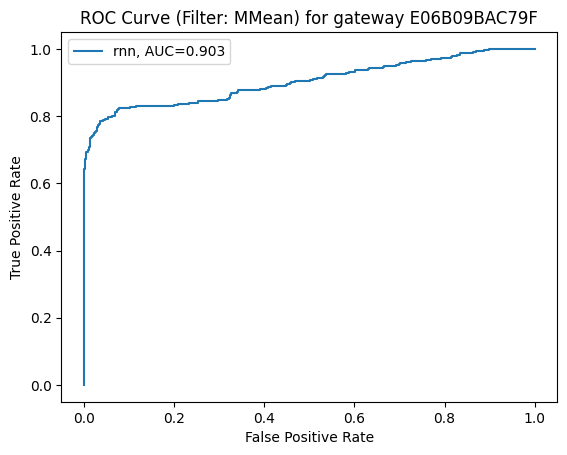

25/25 [==============================] - 1s 28ms/step


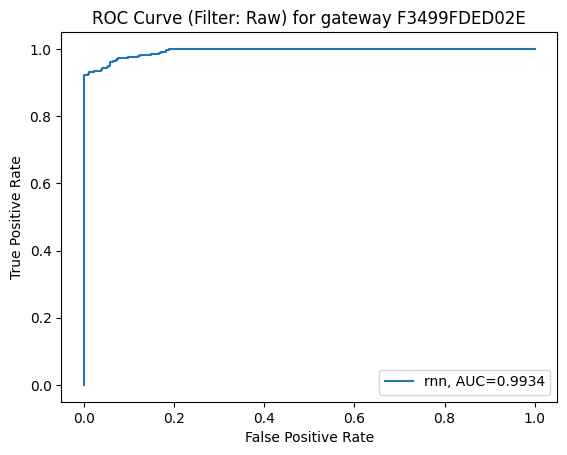

In [ ]:
dict_with_trained_models = {best_model_type: {}}

for gateway in dict_best_accuracy.keys():
  df = test_open_door_dict.get(gateway).get('extended_data')
  #Reduce to only signals of beacons that are from the specific beacon type
  df = df.loc[df.majorminor.isin(majorminor_of_beacon_model_list)].copy()
  #Get filter from directory
  filter = best_gateway_filter.get(gateway)
  #Threshold by best/choosen beacon model
  threshold = dict_best_accuracy[gateway][best_model_type][filter]['threshold'].get(best_beacon_model)
  model = dict_best_accuracy[gateway][best_model_type][filter].get('model')

  title = f'ROC Curve (Filter: {filter}) for gateway {gateway}'

  dict_with_trained_models[best_model_type]['model'] = model
  dict_with_trained_models[best_model_type]['threshold'] = threshold

  X_test, y_test = get_seperated_X_y(df, filter, best_model_type)

  plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title)

9/9 [==============================] - 0s 27ms/step


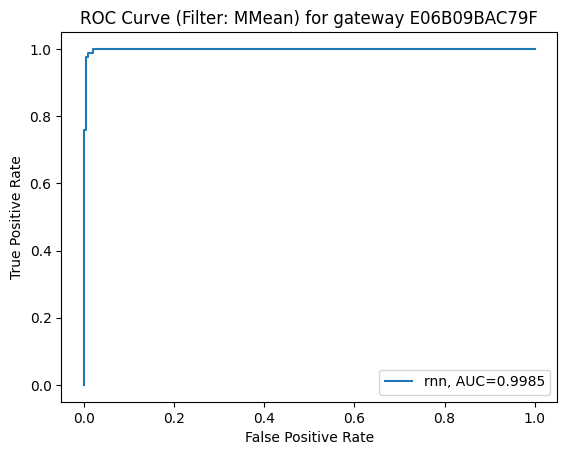

9/9 [==============================] - 0s 26ms/step


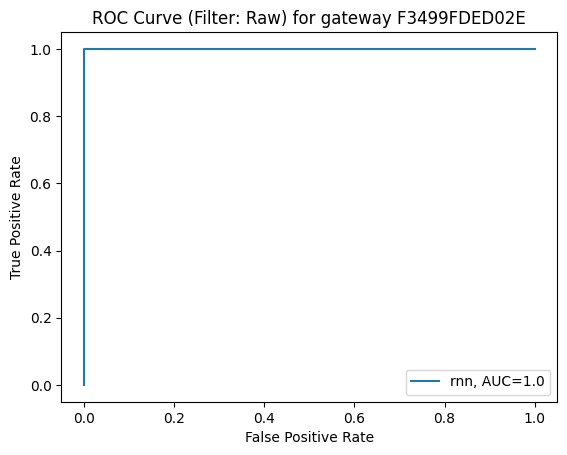

In [ ]:
dict_with_trained_models = {best_model_type: {}}

for gateway in dict_best_accuracy.keys():
  df = test_closed_door_dict.get(gateway).get('extended_data')
  #Reduce to only signals of beacons that are from the specific beacon type
  df = df.loc[df.majorminor.isin(majorminor_of_beacon_model_list)].copy()
  #Get filter from directory
  filter = best_gateway_filter.get(gateway)
  #Threshold by best/choosen beacon model
  threshold = dict_best_accuracy[gateway][best_model_type][filter]['threshold'].get(best_beacon_model)
  model = dict_best_accuracy[gateway][best_model_type][filter].get('model')

  title = f'ROC Curve (Filter: {filter}) for gateway {gateway}'

  dict_with_trained_models[best_model_type]['model'] = model
  dict_with_trained_models[best_model_type]['threshold'] = threshold

  X_test, y_test = get_seperated_X_y(df, filter, best_model_type)

  plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title)

##Konfusionsmatrix 
(noch zu definieren für welche Auswertungen das gemacht wird)

31/31 [==============================] - 1s 27ms/step


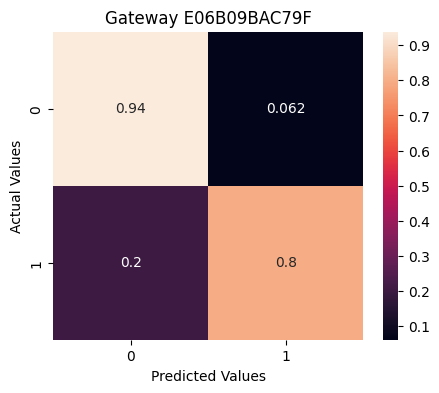

25/25 [==============================] - 1s 29ms/step


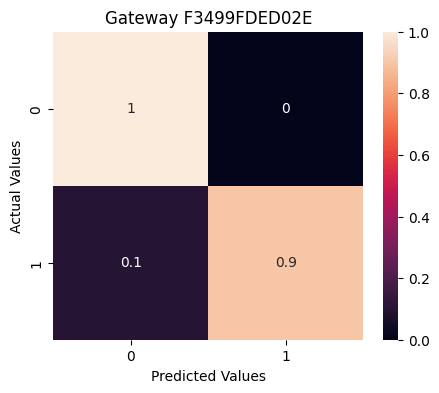

In [ ]:
for gateway in dict_best_accuracy.keys():
  df = test_open_door_dict.get(gateway).get('extended_data')
  #Reduce to only signals of beacons that are from the specific beacon type
  df = df.loc[df.majorminor.isin(majorminor_of_beacon_model_list)].copy()
  #Get filter from directory
  filter = best_gateway_filter.get(gateway)
  #Threshold by best/choosen beacon model
  threshold = dict_best_accuracy[gateway][best_model_type][filter]['threshold'].get(best_beacon_model)
  model = dict_best_accuracy[gateway][best_model_type][filter].get('model')

  title = f'Gateway {gateway}'

  X_test, y_test = get_seperated_X_y(df, filter, best_model_type)

  plot_confusion_matrix(model, best_model_type, threshold, X_test, y_test, title)

9/9 [==============================] - 0s 29ms/step


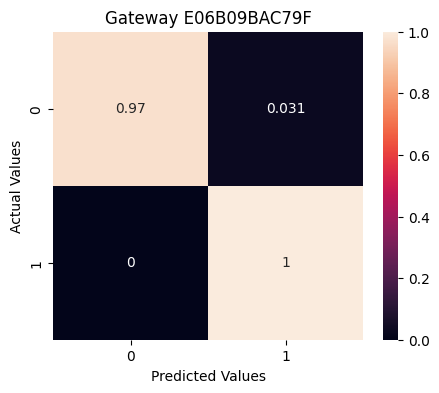

9/9 [==============================] - 0s 28ms/step


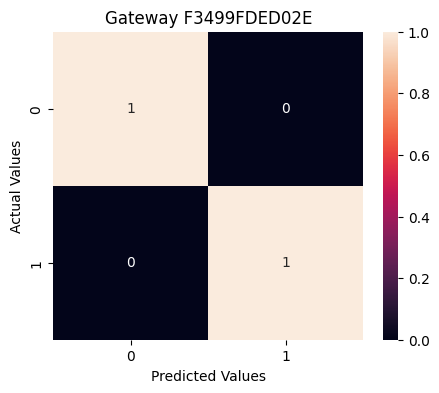

In [ ]:
for gateway in dict_best_accuracy.keys():
  df = test_closed_door_dict.get(gateway).get('extended_data')
  #Reduce to only signals of beacons that are from the specific beacon type
  df = df.loc[df.majorminor.isin(majorminor_of_beacon_model_list)].copy()
  #Get filter from directory
  filter = best_gateway_filter.get(gateway)
  #Threshold by best/choosen beacon model
  threshold = dict_best_accuracy[gateway][best_model_type][filter]['threshold'].get(best_beacon_model)
  model = dict_best_accuracy[gateway][best_model_type][filter].get('model')

  title = f'Gateway {gateway}'

  X_test, y_test = get_seperated_X_y(df, filter, best_model_type)

  plot_confusion_matrix(model, best_model_type, threshold, X_test, y_test, title)

#Effektive Aufenthaltsschätzung des finalen Modell vs reale Aufenthaltsdauer je Raum
Vergleicht die effektive Aufenthaltsdauer in den Räumen mit der vom Modell geschätzten Aufenthaltsdauer

In [ ]:
def get_time_in_room_in_seconds(df, target = 'InRoom'):
  #Gets min and max value as reference
  min_timestamp = df.timestamp.min()
  max_timestamp = df.timestamp.max()

  #Add flag for easier recognition of changes (avoiding iteration through every row)
  df['flag_change'] = df[target].shift() != df[target]

  #Parts the dataframe so it only contains only rows in which the value has changed and also the first and last row
  partion_df = df.loc[(df.flag_change | (df.timestamp == min_timestamp) | (df.timestamp == max_timestamp)),[target,'timestamp']].copy()
  time_in_room = 0

  for index, row in partion_df.iterrows():
    #Direct access via row not possible as target can have a different column name
    current_y = df.loc[df.index == index, target].item()
    #Loads current timestamp
    current_timestamp = row.timestamp

    #Skips rest as it is the first entry and therefore the initial start timestamp
    if current_timestamp == min_timestamp:
      start_timestamp = current_timestamp
      continue  
  
    #Sets final end timestamp as it is the last entry
    if current_timestamp == max_timestamp:
      prev_y = current_y
      end_timestamp = current_timestamp
    #Target value has changed in comparison to previous value
    #
    else:
      prev_y = df.loc[df.index == index-1, target].item()
      end_timestamp = df.loc[df.index == index-1].timestamp.item()

    #If target value is positive the time difference of the start and end timestamps gets added to time in room
    if prev_y == 1:
      time_in_room += end_timestamp - start_timestamp
    #Sets start timestamp with current value as it starts with new target value
    start_timestamp = current_timestamp

  return time_in_room

In [ ]:
def evaluate_precision(data_dict):
  for gateway in dict_best_accuracy.keys():
    master_df = data_dict.get(gateway).get('extended_data')
    for majorminor in majorminor_of_beacon_model_list:
      #Reduce to only signals of beacons that are from the specific beacon type and current majorminor (beacon)
      df = master_df.loc[master_df.majorminor == majorminor].copy().reset_index(drop=True)
      #Get filter from directory
      filter = best_gateway_filter.get(gateway)
  
      X, y = get_seperated_X_y(df, filter, best_model_type, shuffle_data=False)
  
      threshold = dict_best_accuracy[gateway][best_model_type][filter]['threshold'].get(best_beacon_model)
      model = dict_best_accuracy[gateway][best_model_type][filter].get('model')

      print(f'Gateway {gateway}')
      print(f'Majorminor {majorminor}')
  
      if best_model_type == 'rnn':
        #Drop first SEQ_LEN-1 entries, as they are used for initial prediction of LSTM / RNN
        df = df.iloc[SEQ_LEN-1:].copy().reset_index(drop=True)
        df['InRoom_pred'] = (model.predict(X)[:, 1] >= threshold) * 1
      else:
        df['InRoom_pred'] = (model.predict_proba(X)[:, 1] >= threshold) * 1
  
      time_in_room = get_time_in_room_in_seconds(df, 'InRoom')
      time_in_room_pred = get_time_in_room_in_seconds(df, 'InRoom_pred')

      print(f'Effective Time {time_in_room} in seconds')
      print(f'Predicted Time {time_in_room_pred} in seconds')

      round(100/time_in_room*time_in_room_pred,2)
  
      print(f'Percentage difference in length of stay: {round(100/time_in_room*(time_in_room_pred-time_in_room),2)}%')

In [ ]:
print('-----------------')
print('Open Door Testset')
evaluate_precision(test_open_door_dict)
print('-----------------')
print('Closed Door Testset')
evaluate_precision(test_closed_door_dict)

-----------------
Open Door Testset
Gateway E06B09BAC79F
Majorminor 1000454480
31/31 [==============================] - 1s 30ms/step
Effective Time 376 in seconds
Predicted Time 325 in seconds
Percentage difference in length of stay: -13.56%
Gateway F3499FDED02E
Majorminor 1000454480
25/25 [==============================] - 1s 30ms/step
Effective Time 441 in seconds
Predicted Time 397 in seconds
Percentage difference in length of stay: -9.98%
-----------------
Closed Door Testset
Gateway E06B09BAC79F
Majorminor 1000454480
9/9 [==============================] - 0s 28ms/step
Effective Time 80 in seconds
Predicted Time 91 in seconds
Percentage difference in length of stay: 13.75%
Gateway F3499FDED02E
Majorminor 1000454480
9/9 [==============================] - 0s 28ms/step
Effective Time 139 in seconds
Predicted Time 139 in seconds
Percentage difference in length of stay: 0.0%


#Nicht Machine Learning Ansatz / Lösung

##Optimierung der Grenzwerte

In [ ]:
def get_best_threshold_for_non_ml(y_true, distance):
  #Values are multiplied by 100 as range can not contain float values the range is unpacked so that it is a "normal" list
  thresholds_list = [*range(90,501,5)]
  #Stores score as it will contain the score at the same index as the used threshold
  #the threshold can be acquired by searching for max score and use index for loading optimal threshold
  list_score = []
  for threshold in thresholds_list:
    #Devide threshold by 100 as it float can not be handled by range
    y_pred = distance <= (threshold / 100)
    f1 = f1_score(y_true, y_pred, average='weighted')
    list_score.append(f1)
  index_best_threshold = list_score.index(max(list_score))
  best_threshold = thresholds_list[index_best_threshold] / 100
  return best_threshold

In [ ]:
best_threshold_list = []
for gateway in dict_best_accuracy.keys():
  #Load train data to optimize threshold on
  temp_master_df = master_train_dict[gateway].get('extended_data')
  
  for filter in dict_filter_distance_columns.keys():
    
    for beacon_model in temp_master_df.beacon_model.unique():
      df = temp_master_df.loc[temp_master_df.beacon_model == beacon_model].copy()
      column_selection = dict_filter_distance_columns.get(filter)

      y_true = df.InRoom
      X = df.loc[:,column_selection]

      best_threshold = get_best_threshold_for_non_ml(y_true, X)

      setting = {'Gateway': gateway, 'Filter': filter, 'Beacon': beacon_model, 'Threshold': best_threshold}
      best_threshold_list.append(setting)
threshold_settings_df = pd.DataFrame.from_dict(best_threshold_list)

##Evaluierung des non ML Ansatz

In [ ]:
score_list = []
for gateway in dict_best_accuracy.keys():
  #Loads both testsets
  master_open_df = test_open_door_dict.get(gateway).get('extended_data')
  master_closed_df = test_closed_door_dict.get(gateway).get('extended_data')
  #Iteration through all beacon models to evaluate by beacon model
  for beacon_model in temp_master_df.beacon_model.unique():
    df_open = master_open_df.loc[master_open_df.beacon_model == beacon_model].copy().reset_index(drop=True)
    df_closed = master_closed_df.loc[master_closed_df.beacon_model == beacon_model].copy().reset_index(drop=True)

    for filter in dict_filter_distance_columns.keys():
      #Gets distance value for prefilter option
      column_selection = dict_filter_distance_columns.get(filter)
      #Selects specific threshold of threshold dataframe
      threshold = threshold_settings_df.loc[((threshold_settings_df.Beacon == beacon_model) & (threshold_settings_df.Filter == filter) & (threshold_settings_df.Gateway == gateway))].Threshold.item()

      y_pred_open = df_open.loc[:,column_selection] <= threshold
      y_true_open = df_open.InRoom

      y_pred_closed = df_closed.loc[:,column_selection] <= threshold
      y_true_closed = df_closed.InRoom
      #Get scores
      f1_test_open = f1_score(y_true_open, y_pred_open, average='weighted')
      f1_test_closed = f1_score(y_true_closed, y_pred_closed, average='weighted')
      
      #get_key_from_value is used to convert the code value of the beacon model to the name of the beacon model
      score = {
          'Gateway':gateway, 'Filter': filter, 'Beacon':get_key_from_value(code_to_beacon_model, beacon_model)[0], 'Out-of-sample F1 Score (Open)':f1_test_open,'Out-of-sample F1 Score (Closed)':f1_test_closed
          }

      #Adds performance evaluation to dictionary
      score_list.append(score)
temp_eval_df = pd.DataFrame.from_dict(score_list)
temp_eval_df.groupby(['Gateway','Beacon','Filter']).sum().round(4).loc[:,['Out-of-sample F1 Score (Open)','Out-of-sample F1 Score (Closed)']]

Out-of-sample F1 Score (Open)  \
Gateway      Beacon      Filter                                   
E06B09BAC79F Axaet PC023 Kalman                          0.7933   
                         MMean                           0.7942   
                         MMedian                         0.8177   
                         Raw                             0.7585   
                         Wiener                          0.7924   
             Axaet PC038 Kalman                          0.9030   
                         MMean                           0.9186   
                         MMedian                         0.8956   
                         Raw                             0.8556   
                         Wiener                          0.9113   
             Axaet PC061 Kalman                          0.7637   
                         MMean                           0.7571   
                         MMedian                         0.7729   
                         Raw                             0.7595   
                         Wiener                          0.7604   
             Feasy P103  Kalman                          0.7310   
                         MMean                           0.7299   
                         MMedian                         0.7132   
                         Raw                             0.6951   
                         Wiener                          0.6659   
             K8          Kalman                          0.8796   
                         MMean                           0.8909   
                         MMedian                         0.8960   
                         Raw                             0.8729   
                         Wiener                          0.8885   
F3499FDED02E Axaet PC023 Kalman                          0.7114   
                         MMean                           0.7231   
                         MMedian                         0.7061   
                         Raw                             0.6859   
                         Wiener                          0.7418   
             Axaet PC038 Kalman                          0.7894   
                         MMean                           0.7819   
                         MMedian                         0.8194   
                         Raw                             0.7623   
                         Wiener                          0.8075   
             Axaet PC061 Kalman                          0.9071   
                         MMean                           0.9096   
                         MMedian                         0.9048   
                         Raw                             0.8502   
                         Wiener                          0.9107   
             Feasy P103  Kalman                          0.5663   
                         MMean                           0.5567   
                         MMedian                         0.6125   
                         Raw                             0.6052   
                         Wiener                          0.5761   
             K8          Kalman                          0.7975   
                         MMean                           0.7915   
                         MMedian                         0.8534   
                         Raw                             0.7861   
                         Wiener                          0.8253   

                                  Out-of-sample F1 Score (Closed)  
Gateway      Beacon      Filter                                    
E06B09BAC79F Axaet PC023 Kalman                            0.8887  
                         MMean                             0.8720  
                         MMedian                           0.8986  
                         Raw                               0.8408  
                         Wiener                            0.8720  
             Axaet PC038 Kalman                            0.8909  
     